## Machine Learning Project
## **Skin Disease Detection**
# 25AI60R24 - Anarva Kamdar
# 25AI60R25 - Adarsh Raj
# 25AI60R26 - Arun Kumar


## **Import The Required libraries**

In [ ]:
# import the Required libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.covariance import EmpiricalCovariance
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
import cv2
import pickle

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


## **Import the Dataset**

In [ ]:
# Import the Dataset
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"adarshraj77","key":"ac6b33acd07eb0ae71fa51cf02bd20d5"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pacificrm/skindiseasedataset
!unzip -q skindiseasedataset.zip -d skin_disease_dataset

print(" Dataset downloaded and extracted successfully!")

# Set dataset directory
DATASET_DIR = 'skin_disease_dataset'
train_dir = os.path.join(DATASET_DIR, 'SkinDisease', 'SkinDisease', 'train')
test_dir = os.path.join(DATASET_DIR, 'SkinDisease', 'SkinDisease', 'test')

Dataset URL: https://www.kaggle.com/datasets/pacificrm/skindiseasedataset
License(s): CC0-1.0
 99% 1.35G/1.36G [00:06<00:00, 260MB/s]
100% 1.36G/1.36G [00:08<00:00, 180MB/s]
 Dataset downloaded and extracted successfully!


## **EXPLORE DATASET STRUCTURE**

In [ ]:
print("DATASET STRUCTURE...")
for root, dirs, files in os.walk(DATASET_DIR):
    level = root.replace(DATASET_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/ -> {len(files)} files")

# Count classes and images
class_counts = {}

for cls in os.listdir(train_dir):
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

for cls in os.listdir(test_dir):
    class_path = os.path.join(test_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = class_counts.get(cls, 0) + len(os.listdir(class_path))

print(f"Total number of classes: {len(class_counts)}")
print(f"Total number of images: {sum(class_counts.values())}")

DATASET STRUCTURE...
skin_disease_dataset/ -> 1 files
  SkinDisease/ -> 0 files
    SkinDisease/ -> 0 files
      train/ -> 0 files
        Rosacea/ -> 254 files
        SkinCancer/ -> 693 files
        Benign_tumors/ -> 1093 files
        Vitiligo/ -> 714 files
        Bullous/ -> 504 files
        Seborrh_Keratoses/ -> 455 files
        Candidiasis/ -> 248 files
        Warts/ -> 580 files
        Vascular_Tumors/ -> 543 files
        Sun_Sunlight_Damage/ -> 312 files
        DrugEruption/ -> 547 files
        Unknown_Normal/ -> 1651 files
        Infestations_Bites/ -> 524 files
        Vasculitis/ -> 461 files
        Moles/ -> 361 files
        Lichen/ -> 553 files
        Acne/ -> 593 files
        Tinea/ -> 923 files
        Lupus/ -> 311 files
        Actinic_Keratosis/ -> 748 files
        Psoriasis/ -> 820 files
        Eczema/ -> 1010 files
      test/ -> 0 files
        Rosacea/ -> 28 files
        SkinCancer/ -> 77 files
        Benign_tumors/ -> 121 files
        Vitiligo

## **plot the number of classes presnt in the Dataset**

CLASS DISTRIBUTION
Unknown_Normal                : 1840 images
Benign_tumors                 : 1214 images
Eczema                        : 1122 images
Tinea                         : 1025 images
Psoriasis                     :  908 images
Actinic_Keratosis             :  831 images
Vitiligo                      :  796 images
SkinCancer                    :  770 images
Acne                          :  658 images
Warts                         :  644 images
Lichen                        :  614 images
DrugEruption                  :  608 images
Vascular_Tumors               :  603 images
Infestations_Bites            :  584 images
Bullous                       :  559 images
Vasculitis                    :  513 images
Seborrh_Keratoses             :  506 images
Moles                         :  401 images
Sun_Sunlight_Damage           :  346 images
Lupus                         :  345 images
Rosacea                       :  282 images
Candidiasis                   :  275 images


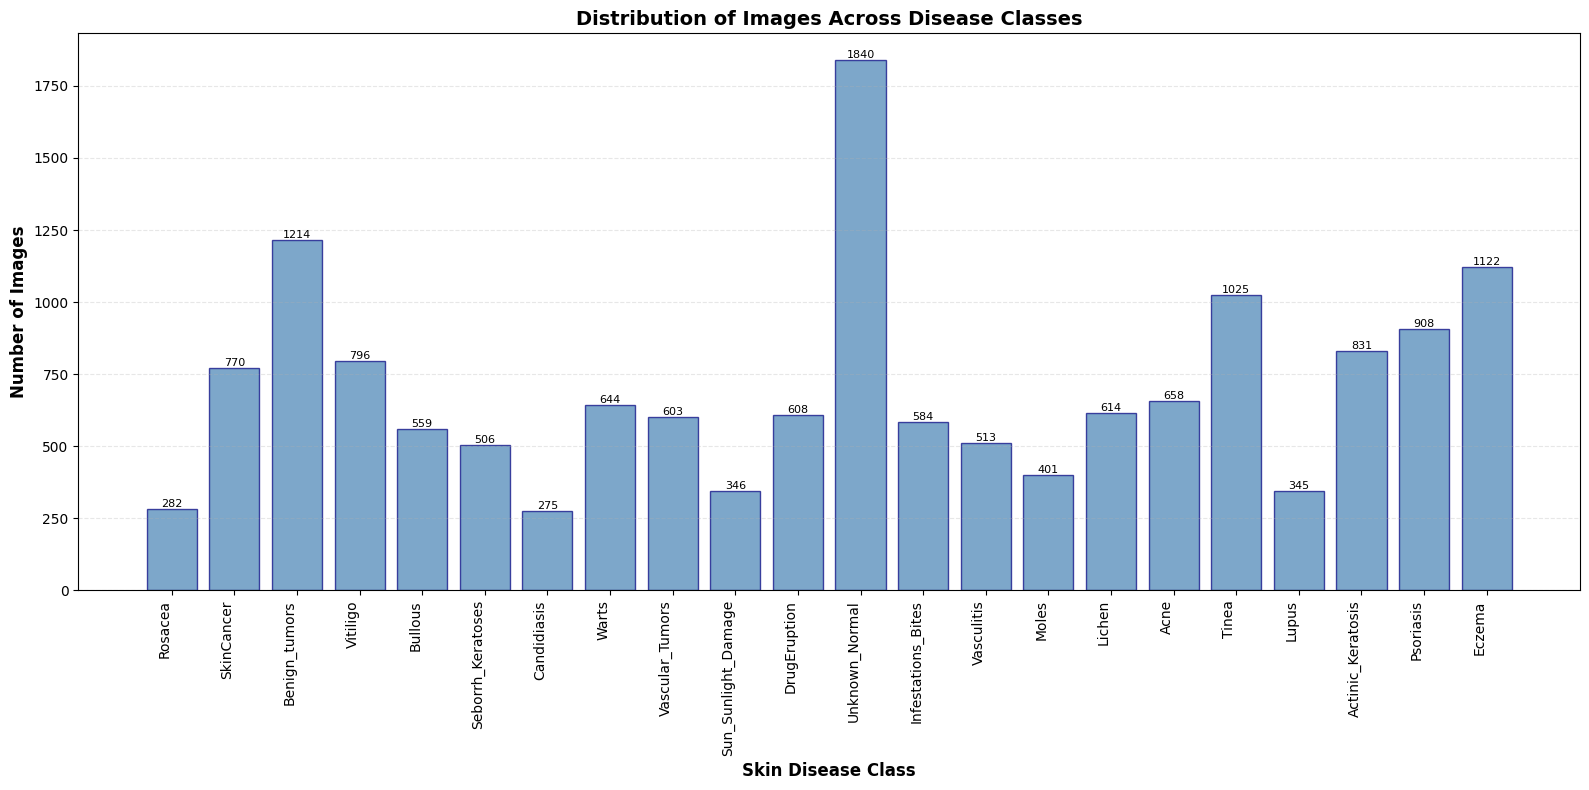

Saved: class_distribution.png


In [ ]:
print("CLASS DISTRIBUTION")

# Print class counts
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls:30s}: {count:4d} images")

# Plot distribution
plt.figure(figsize=(16, 8))
classes = list(class_counts.keys())
counts = list(class_counts.values())

bars = plt.bar(classes, counts, color='steelblue', edgecolor='navy', alpha=0.7)
plt.xticks(rotation=90, ha='right')
plt.xlabel('Skin Disease Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Distribution of Images Across Disease Classes', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: class_distribution.png")

## **DATA PREPROCESSING**

In [ ]:
# print total no of images
print(f"Total number of images: {sum(class_counts.values())}")

Total number of images: 15444


In [ ]:
# Separate train and test counts
train_counts = {}
test_counts = {}

for cls in os.listdir(train_dir):
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        train_counts[cls] = len(os.listdir(class_path))

for cls in os.listdir(test_dir):
    class_path = os.path.join(test_dir, cls)
    if os.path.isdir(class_path):
        test_counts[cls] = len(os.listdir(class_path))

print(f"Total training images: {sum(train_counts.values())}")
print(f"Total testing images: {sum(test_counts.values())}\n")

Total training images: 13898
Total testing images: 1546



In [ ]:
def validate_images(directory):
    """Remove corrupted images"""
    corrupted = []
    total = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                total += 1
                try:
                    img = Image.open(img_path)
                    img.verify()
                except:
                    corrupted.append(img_path)
                    print(f"✗ Removing corrupted: {img_path}")
                    try:
                        os.remove(img_path)
                    except:
                        pass

    return corrupted, total

print("Validating training images...")
train_corrupted, train_total = validate_images(train_dir)
print(f"✓ Train: {train_total - len(train_corrupted)}/{train_total} valid")

print("\nValidating testing images...")
test_corrupted, test_total = validate_images(test_dir)
print(f"✓ Test: {test_total - len(test_corrupted)}/{test_total} valid")

print(f"\nTotal corrupted images removed: {len(train_corrupted) + len(test_corrupted)}")

Validating training images...
✓ Train: 13898/13898 valid

Validating testing images...
✓ Test: 1546/1546 valid

Total corrupted images removed: 0


## **DATA TRANSFORMATION**

In [ ]:
print("Data Preprocessing and Transformation...... ")
IMG_SIZE = 224
BATCH_SIZE = 64

# Training transformations with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Data transformations defined")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Augmentations: Flip, Rotation, Color Jitter, Affine")

Data Preprocessing and Transformation...... 
✓ Data transformations defined
  Image size: 224x224
  Batch size: 64
  Augmentations: Flip, Rotation, Color Jitter, Affine


In [ ]:
print("DATASET STRUCTURE...")
for root, dirs, files in os.walk(DATASET_DIR):
    level = root.replace(DATASET_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/ -> {len(files)} files")

# Count classes and images
class_counts = {}

for cls in os.listdir(train_dir):
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))

for cls in os.listdir(test_dir):
    class_path = os.path.join(test_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = class_counts.get(cls, 0) + len(os.listdir(class_path))

print(f"Total number of classes: {len(class_counts)}")
print(f"Total number of images: {sum(class_counts.values())}")

DATASET STRUCTURE...
skin_disease_dataset/ -> 1 files
  SkinDisease/ -> 0 files
    SkinDisease/ -> 0 files
      train/ -> 0 files
        Rosacea/ -> 254 files
        SkinCancer/ -> 693 files
        Benign_tumors/ -> 1093 files
        Vitiligo/ -> 714 files
        Bullous/ -> 504 files
        Seborrh_Keratoses/ -> 455 files
        Candidiasis/ -> 248 files
        Warts/ -> 580 files
        Vascular_Tumors/ -> 543 files
        Sun_Sunlight_Damage/ -> 312 files
        DrugEruption/ -> 547 files
        Unknown_Normal/ -> 1651 files
        Infestations_Bites/ -> 524 files
        Vasculitis/ -> 461 files
        Moles/ -> 361 files
        Lichen/ -> 553 files
        Acne/ -> 593 files
        Tinea/ -> 923 files
        Lupus/ -> 311 files
        Actinic_Keratosis/ -> 748 files
        Psoriasis/ -> 820 files
        Eczema/ -> 1010 files
      test/ -> 0 files
        Rosacea/ -> 28 files
        SkinCancer/ -> 77 files
        Benign_tumors/ -> 121 files
        Vitiligo

## **plot the number of classes presnt in the Dataset**

CLASS DISTRIBUTION
Unknown_Normal                : 1840 images
Benign_tumors                 : 1214 images
Eczema                        : 1122 images
Tinea                         : 1025 images
Psoriasis                     :  908 images
Actinic_Keratosis             :  831 images
Vitiligo                      :  796 images
SkinCancer                    :  770 images
Acne                          :  658 images
Warts                         :  644 images
Lichen                        :  614 images
DrugEruption                  :  608 images
Vascular_Tumors               :  603 images
Infestations_Bites            :  584 images
Bullous                       :  559 images
Vasculitis                    :  513 images
Seborrh_Keratoses             :  506 images
Moles                         :  401 images
Sun_Sunlight_Damage           :  346 images
Lupus                         :  345 images
Rosacea                       :  282 images
Candidiasis                   :  275 images


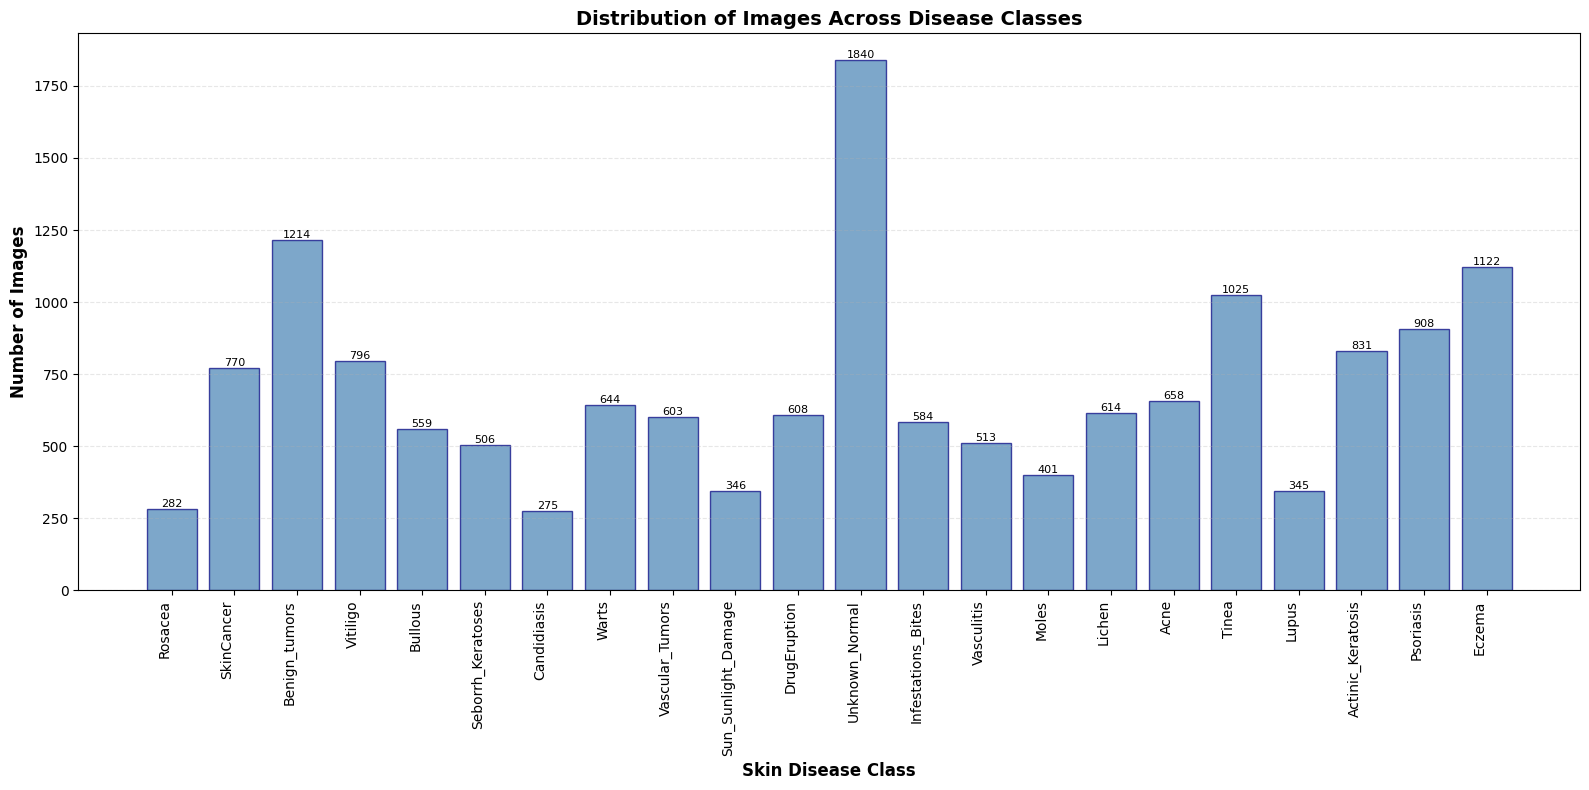

Saved: class_distribution.png


In [ ]:
print("CLASS DISTRIBUTION")

# Print class counts
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls:30s}: {count:4d} images")

# Plot distribution
plt.figure(figsize=(16, 8))
classes = list(class_counts.keys())
counts = list(class_counts.values())

bars = plt.bar(classes, counts, color='steelblue', edgecolor='navy', alpha=0.7)
plt.xticks(rotation=90, ha='right')
plt.xlabel('Skin Disease Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Distribution of Images Across Disease Classes', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: class_distribution.png")

# SEVERITY CLASSIFICATION MAPPING

In [ ]:
SEVERITY_MAPPING = {
    # Mild
    'Acne': 'MILD',
    'Candidiasis': 'MILD',
    'Eczema': 'MILD',
    'Infestations_Bites': 'MILD',
    'Rosacea': 'MILD',
    'Warts': 'MILD',
    'Tinea': 'MILD',

    # Moderate
    'Bullous': 'MODERATE',
    'DrugEruption': 'MODERATE',
    'Lichen': 'MODERATE',
    'Moles': 'MODERATE',
    'Seborrh_Keratoses': 'MODERATE',
    'Benign_tumors': 'MODERATE',

    # Severe
    'Actinic_Keratosis': 'SEVERE',
    'Lupus': 'SEVERE',
    'Psoriasis': 'SEVERE',
    'SkinCancer': 'SEVERE',
    'Vasculitis': 'SEVERE',
    'Vascular_Tumors': 'SEVERE',

    # Other
    'Vitiligo': 'OTHER',
    'Sun_Sunlight_Damage': 'OTHER',
    'Unknown_Normal': 'OTHER'
}

SEVERITY_COLORS = {
    'MILD': '#4CAF50',      # Green
    'MODERATE': '#FF9800',  # Orange
    'SEVERE': '#F44336',    # Red
    'OTHER': '#9E9E9E'      # Gray
}

SEVERITY_ORDER = ['MILD', 'MODERATE', 'SEVERE', 'OTHER']

def get_severity(class_name):
    """Get severity level for a disease class"""
    return SEVERITY_MAPPING.get(class_name, 'OTHER')

print("\n✓ Severity mapping configured")
print(f"  Mild: {sum(1 for v in SEVERITY_MAPPING.values() if v == 'MILD')} classes")
print(f"  Moderate: {sum(1 for v in SEVERITY_MAPPING.values() if v == 'MODERATE')} classes")
print(f"  Severe: {sum(1 for v in SEVERITY_MAPPING.values() if v == 'SEVERE')} classes")
print(f"  Other: {sum(1 for v in SEVERITY_MAPPING.values() if v == 'OTHER')} classes")


✓ Severity mapping configured
  Mild: 7 classes
  Moderate: 6 classes
  Severe: 6 classes
  Other: 3 classes


In [ ]:
SEVERITY_PRIORITY = {
    # SEVERE (highest priority)
    'Actinic_Keratosis': 1,
    'Lupus': 2,
    'Psoriasis': 3,
    'SkinCancer': 4,
    'Vasculitis': 5,
    'Vascular_Tumors': 6,

    # MODERATE
    'Bullous': 7,
    'DrugEruption': 8,
    'Lichen': 9,
    'Moles': 10,
    'Seborrh_Keratoses': 11,
    'Benign_tumors': 12,

    # MILD
    'Acne': 13,
    'Candidiasis': 14,
    'Eczema': 15,
    'Infestations_Bites': 16,
    'Rosacea': 17,
    'Warts': 18,
    'Tinea': 19,

    # OTHER (lowest priority)
    'Unknown_Normal': 20,
    'Vitiligo': 21,
    'Sun_Sunlight_Damage': 22
}

def get_priority(class_name):
    return SEVERITY_PRIORITY.get(class_name, 99)  # default lowest priority



# Example print
for disease, priority in SEVERITY_PRIORITY.items():
    print(f"{disease}: priority {priority}")

Actinic_Keratosis: priority 1
Lupus: priority 2
Psoriasis: priority 3
SkinCancer: priority 4
Vasculitis: priority 5
Vascular_Tumors: priority 6
Bullous: priority 7
DrugEruption: priority 8
Lichen: priority 9
Moles: priority 10
Seborrh_Keratoses: priority 11
Benign_tumors: priority 12
Acne: priority 13
Candidiasis: priority 14
Eczema: priority 15
Infestations_Bites: priority 16
Rosacea: priority 17
Warts: priority 18
Tinea: priority 19
Unknown_Normal: priority 20
Vitiligo: priority 21
Sun_Sunlight_Damage: priority 22


## **plot the number of classes presnt in the Dataset**

CLASS DISTRIBUTION WITH SEVERITY MAPPING


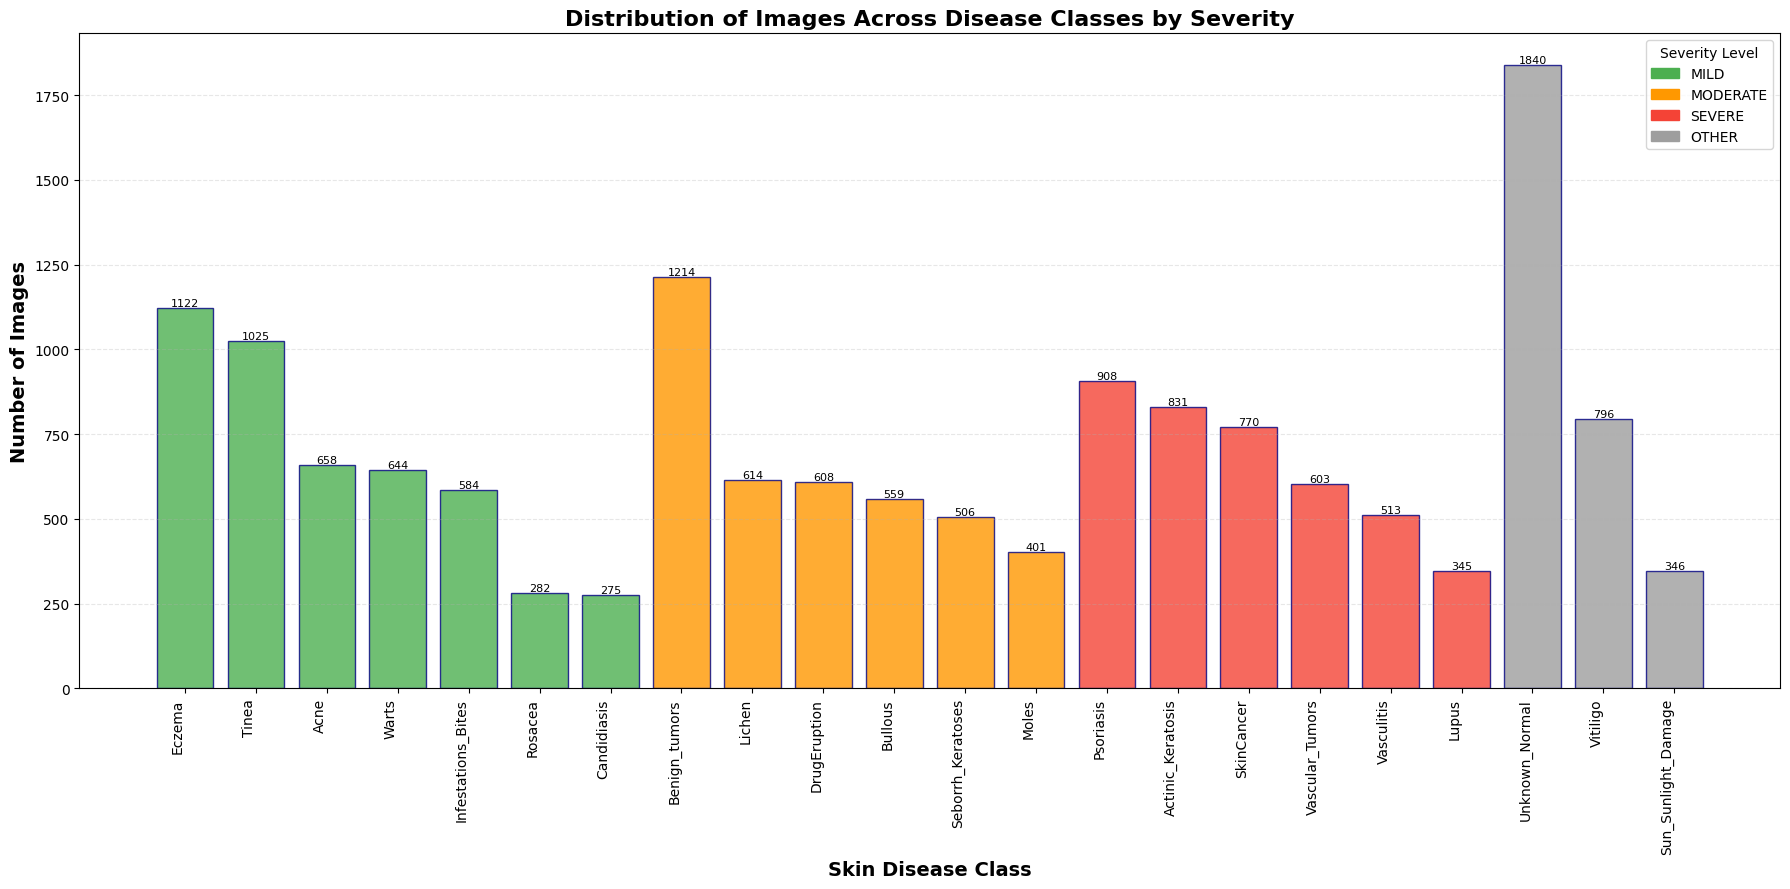

Saved: class_distribution_by_severity.png


In [ ]:
print("CLASS DISTRIBUTION WITH SEVERITY MAPPING")

# Create a DataFrame for easier sorting and plotting
plot_df = pd.DataFrame({
    'Class': class_counts.keys(),
    'Count': class_counts.values()
})
plot_df['Severity'] = plot_df['Class'].apply(get_severity)

# Sort by severity order, then by count within each severity
plot_df['Severity_Order'] = plot_df['Severity'].map(lambda x: SEVERITY_ORDER.index(x))
plot_df = plot_df.sort_values(by=['Severity_Order', 'Count'], ascending=[True, False])

# Prepare data for plotting
classes_sorted = plot_df['Class'].tolist()
counts_sorted = plot_df['Count'].tolist()
severity_colors_sorted = plot_df['Severity'].map(SEVERITY_COLORS).tolist()

plt.figure(figsize=(18, 9))
bars = plt.bar(classes_sorted, counts_sorted,
               color=severity_colors_sorted, edgecolor='navy', alpha=0.8)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.xlabel('Skin Disease Class', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images', fontsize=14, fontweight='bold')
plt.title('Distribution of Images Across Disease Classes by Severity', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=8)

# Create custom legend for severity colors
import matplotlib.patches as mpatches
legend_handles = []
for severity, color in SEVERITY_COLORS.items():
    if severity in plot_df['Severity'].unique(): # Only add if severity is present in data
        legend_handles.append(mpatches.Patch(color=color, label=severity))
plt.legend(handles=legend_handles, title='Severity Level', loc='upper right', frameon=True)

plt.tight_layout()
plt.savefig('class_distribution_by_severity.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: class_distribution_by_severity.png")

VISUALIZING DISEASE PRIORITIES


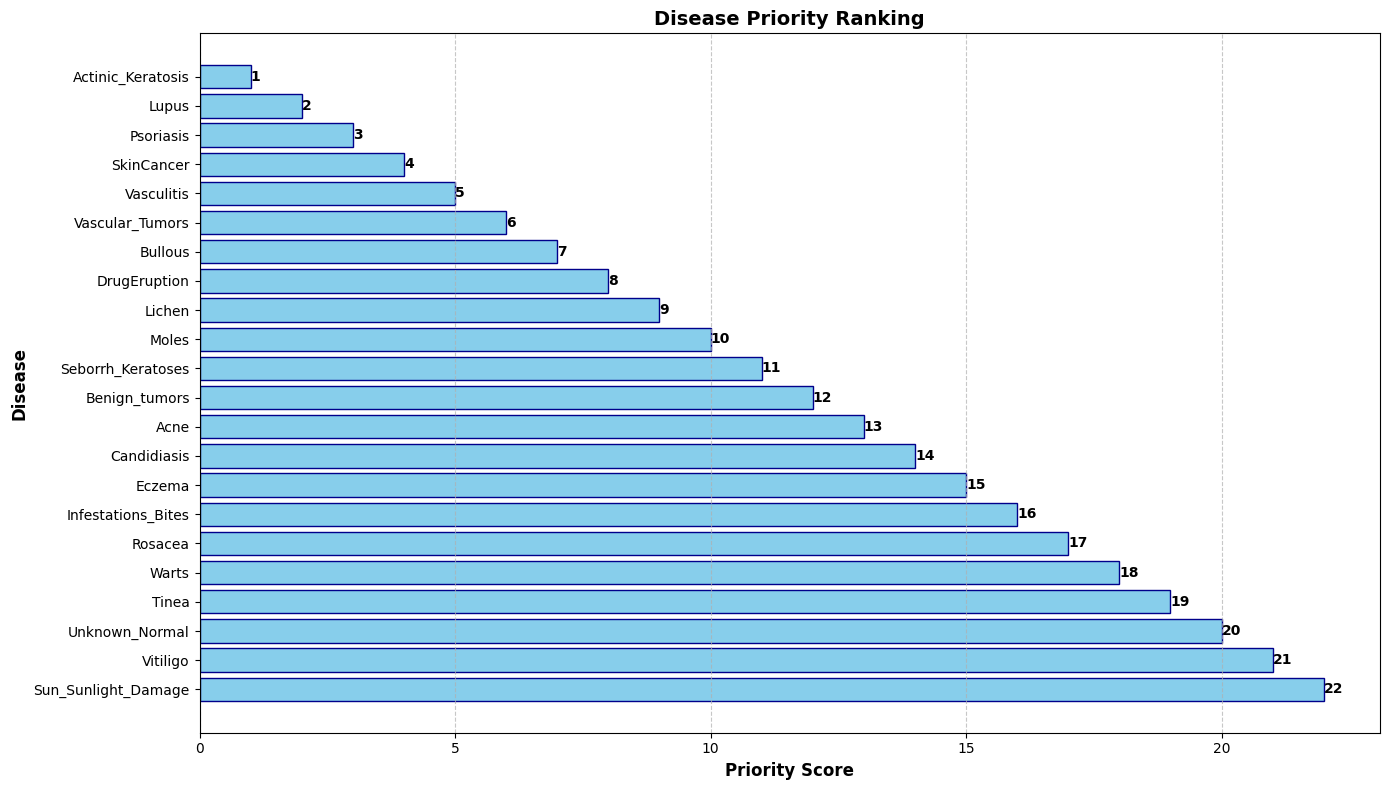

Saved: disease_priority_ranking.png


In [ ]:
print("VISUALIZING DISEASE PRIORITIES")

# Create a DataFrame from the SEVERITY_PRIORITY dictionary
priority_df = pd.DataFrame(SEVERITY_PRIORITY.items(), columns=['Disease', 'Priority'])

# Sort by priority in descending order for better visualization
priority_df = priority_df.sort_values(by='Priority', ascending=False)

plt.figure(figsize=(14, 8))
bars = plt.barh(priority_df['Disease'], priority_df['Priority'], color='skyblue', edgecolor='darkblue')

plt.xlabel('Priority Score', fontsize=12, fontweight='bold')
plt.ylabel('Disease', fontsize=12, fontweight='bold')
plt.title('Disease Priority Ranking', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add priority scores on the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{int(bar.get_width())}',
             va='center', ha='left', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.savefig('disease_priority_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: disease_priority_ranking.png")

## **DATA PREPROCESSING**

In [ ]:
# print total no of images
print(f"Total number of images: {sum(class_counts.values())}")

Total number of images: 15444


In [ ]:
# Separate train and test counts
train_counts = {}
test_counts = {}

for cls in os.listdir(train_dir):
    class_path = os.path.join(train_dir, cls)
    if os.path.isdir(class_path):
        train_counts[cls] = len(os.listdir(class_path))

for cls in os.listdir(test_dir):
    class_path = os.path.join(test_dir, cls)
    if os.path.isdir(class_path):
        test_counts[cls] = len(os.listdir(class_path))

print(f"Total training images: {sum(train_counts.values())}")
print(f"Total testing images: {sum(test_counts.values())}\n")

Total training images: 13898
Total testing images: 1546



In [ ]:
def validate_images(directory):
    """Remove corrupted images"""
    corrupted = []
    total = 0

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                total += 1
                try:
                    img = Image.open(img_path)
                    img.verify()
                except:
                    corrupted.append(img_path)
                    print(f"✗ Removing corrupted: {img_path}")
                    try:
                        os.remove(img_path)
                    except:
                        pass

    return corrupted, total

print("Validating training images...")
train_corrupted, train_total = validate_images(train_dir)
print(f"✓ Train: {train_total - len(train_corrupted)}/{train_total} valid")

print("\nValidating testing images...")
test_corrupted, test_total = validate_images(test_dir)
print(f"✓ Test: {test_total - len(test_corrupted)}/{test_total} valid")

print(f"\nTotal corrupted images removed: {len(train_corrupted) + len(test_corrupted)}")

Validating training images...
✓ Train: 13898/13898 valid

Validating testing images...
✓ Test: 1546/1546 valid

Total corrupted images removed: 0


In [ ]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except:
            # If corrupted, return next image
            return self.__getitem__((idx + 1) % len(self))

# Create datasets
train_dataset = SkinDiseaseDataset(train_dir, transform=train_transform)
test_dataset = SkinDiseaseDataset(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✓ Datasets created successfully!")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Testing samples: {len(test_dataset)}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Testing batches: {len(test_loader)}")
print(f"  Number of classes: {len(train_dataset.classes)}")


✓ Datasets created successfully!
  Training samples: 13898
  Testing samples: 1546
  Training batches: 218
  Testing batches: 25
  Number of classes: 22


## **VISUALIZE SAMPLE IMAGES**

SAMPLE IMAGES VISUALIZATION


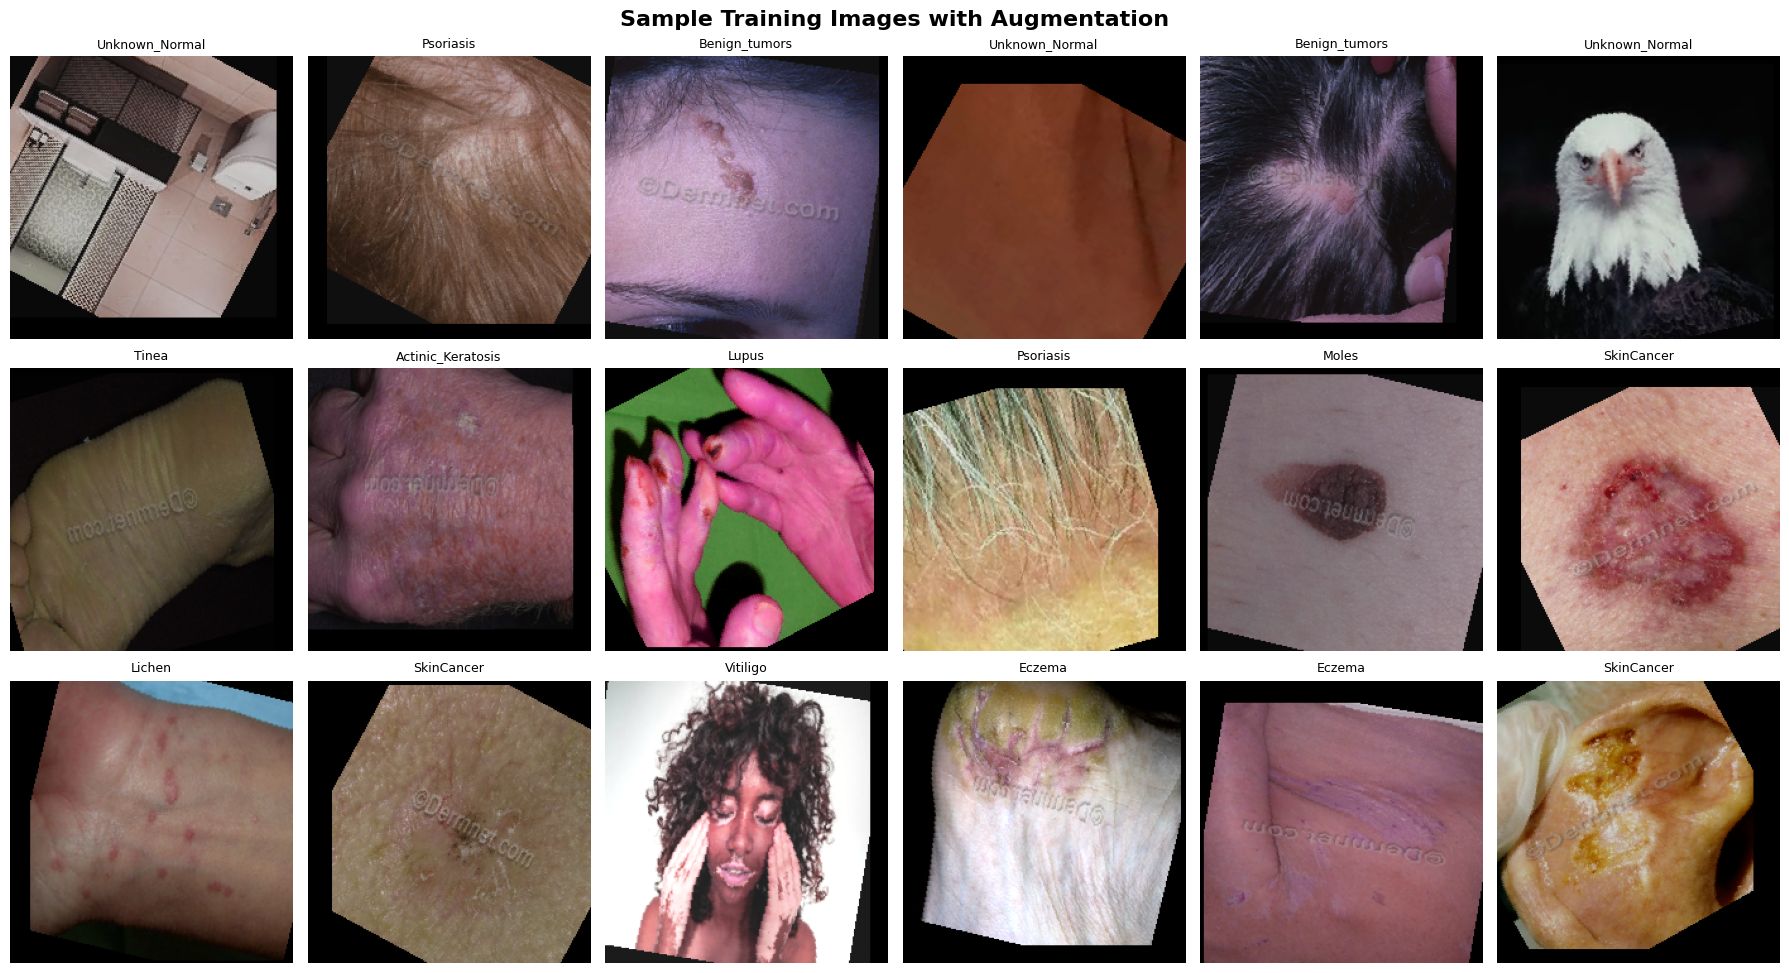

Saved: sample_images.png


In [ ]:
print("SAMPLE IMAGES VISUALIZATION")

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Denormalize for visualization
def denormalize(tensor):
    tensor = tensor.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# Plot sample images
fig, axes = plt.subplots(3, 6, figsize=(18, 10))
fig.suptitle('Sample Training Images with Augmentation', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        img = denormalize(images[idx])
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(train_dataset.classes[labels[idx]][:20], fontsize=9)
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: sample_images.png")

# **HYBRID FEATURE EXTRACTOR (ResNet50 + DenseNet121)**

In [ ]:
print("BUILDING HYBRID FEATURE EXTRACTOR (ResNet50 + DenseNet121)")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class HybridFeatureExtractor(nn.Module):
    """
    Hybrid Feature Extractor combining ResNet50 and DenseNet121

    Architecture:
    Input Image (3x224x224)
         │
         ├──► ResNet50 (no classifier) ──► Feature_1 (2048-dim)
         │
         └──► DenseNet121 (no classifier) ──► Feature_2 (1024-dim)
              │
              └──► Concatenate → Combined Feature (3072-dim)
    """
    def __init__(self):
        super(HybridFeatureExtractor, self).__init__()

        # ResNet50 feature extractor
        resnet = models.resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        self.resnet_feat_dim = 2048

        # DenseNet121 feature extractor
        densenet = models.densenet121(pretrained=True)
        self.densenet_features = densenet.features
        self.densenet_feat_dim = 1024

        # Combined feature dimension
        self.combined_feat_dim = self.resnet_feat_dim + self.densenet_feat_dim

        # Adaptive pooling for DenseNet
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Store references for Grad-CAM
        self.resnet_last_conv = list(resnet.children())[-2]
        self.densenet_last_conv = densenet.features.denseblock4

    def forward(self, x):
        # Extract ResNet features
        resnet_feat = self.resnet_features(x)
        resnet_feat = resnet_feat.view(resnet_feat.size(0), -1)

        # Extract DenseNet features
        densenet_feat = self.densenet_features(x)
        densenet_feat = self.adaptive_pool(densenet_feat)
        densenet_feat = densenet_feat.view(densenet_feat.size(0), -1)

        # Concatenate features
        combined_feat = torch.cat([resnet_feat, densenet_feat], dim=1)

        return combined_feat, resnet_feat, densenet_feat

# Initialize feature extractor
feature_extractor = HybridFeatureExtractor().to(device)
feature_extractor.eval()

print(f"\n✓ Feature Extractor initialized")
print(f"  ResNet50 feature dimension: {feature_extractor.resnet_feat_dim}")
print(f"  DenseNet121 feature dimension: {feature_extractor.densenet_feat_dim}")
print(f"  Combined feature dimension: {feature_extractor.combined_feat_dim}")

BUILDING HYBRID FEATURE EXTRACTOR (ResNet50 + DenseNet121)
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 52.5MB/s]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 82.5MB/s]



✓ Feature Extractor initialized
  ResNet50 feature dimension: 2048
  DenseNet121 feature dimension: 1024
  Combined feature dimension: 3072


MODEL PARAMETERS

In [ ]:
print("MODEL PARAMETERS ANALYSIS")

def count_parameters(model):
    """Count trainable and total parameters"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Get parameter counts for individual models
resnet = models.resnet50(pretrained=True)
densenet = models.densenet121(pretrained=True)

resnet_total, resnet_trainable = count_parameters(resnet)
densenet_total, densenet_trainable = count_parameters(densenet)
hybrid_total, hybrid_trainable = count_parameters(feature_extractor)

print(f"\nResNet50:")
print(f"  Total Parameters: {resnet_total:,}")
print(f"  Trainable Parameters: {resnet_trainable:,}")

print(f"\nDenseNet121:")
print(f"  Total Parameters: {densenet_total:,}")
print(f"  Trainable Parameters: {densenet_trainable:,}")

print(f"\nHybrid Feature Extractor:")
print(f"  Total Parameters: {hybrid_total:,}")
print(f"  Trainable Parameters: {hybrid_trainable:,}")
print(f"  Feature Dimension: {feature_extractor.combined_feat_dim}")

MODEL PARAMETERS ANALYSIS

ResNet50:
  Total Parameters: 25,557,032
  Trainable Parameters: 25,557,032

DenseNet121:
  Total Parameters: 7,978,856
  Trainable Parameters: 7,978,856

Hybrid Feature Extractor:
  Total Parameters: 30,461,888
  Trainable Parameters: 30,461,888
  Feature Dimension: 3072


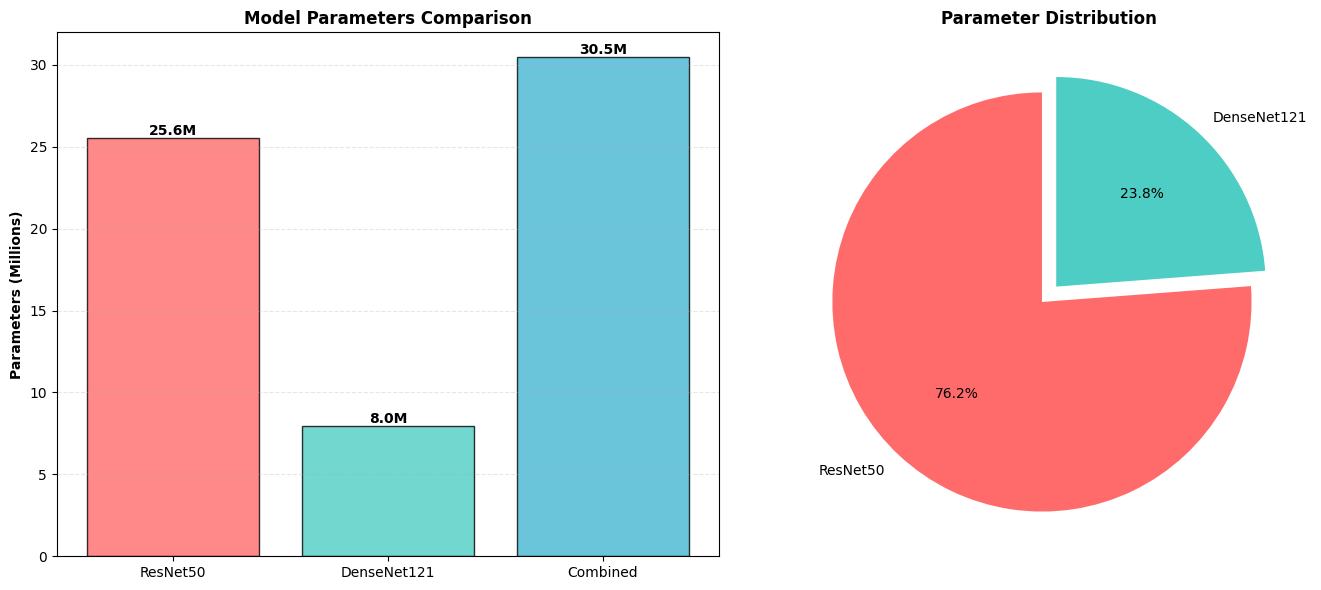

Saved: model_parameters.png


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
models_names = ['ResNet50', 'DenseNet121', 'Combined']
params = [resnet_total/1e6, densenet_total/1e6, hybrid_total/1e6]

bars = ax1.bar(models_names, params, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
               edgecolor='black', alpha=0.8)
ax1.set_ylabel('Parameters (Millions)', fontweight='bold')
ax1.set_title('Model Parameters Comparison', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}M',
             ha='center', va='bottom', fontweight='bold')

# Pie chart
ax2.pie([resnet_total, densenet_total],
        labels=['ResNet50', 'DenseNet121'],
        autopct='%1.1f%%',
        colors=['#FF6B6B', '#4ECDC4'],
        startangle=90,
        explode=(0.05, 0.05))
ax2.set_title('Parameter Distribution', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('model_parameters.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: model_parameters.png")

## **EXTRACTING FEATURES**

In [ ]:
def extract_features(model, dataloader, device):
    """Extract features from all samples"""
    model.eval()
    all_features = []
    all_labels = []

    print("Progress: ", end='')
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            combined_feat, _, _ = model(inputs)
            all_features.append(combined_feat.cpu().numpy())
            all_labels.append(labels.numpy())

            if (batch_idx + 1) % 50 == 0:
                print(f"{batch_idx + 1}/{len(dataloader)}...", end=' ')

    print("Done!")

    features = np.vstack(all_features)
    labels = np.hstack(all_labels)
    return features, labels

print("\n[1/2] Extracting training features...")
train_features, train_labels = extract_features(feature_extractor, train_loader, device)
print(f" Training features shape: {train_features.shape}")

print("\n[2/2] Extracting testing features...")
test_features, test_labels = extract_features(feature_extractor, test_loader, device)
print(f" Testing features shape: {test_features.shape}")


[1/2] Extracting training features...
Progress: 50/218... 100/218... 150/218... 200/218... Done!
 Training features shape: (13898, 3072)

[2/2] Extracting testing features...
Progress: Done!
 Testing features shape: (1546, 3072)


## **DIMENSIONALITY REDUCTION**

PCA DIMENSIONALITY REDUCTION ANALYSIS
  Variance Analysis:
  Components for 95% variance: 494 (16.1% of original)
  Components for 99% variance: 1025 (33.4% of original)
  Original dimension: 3072


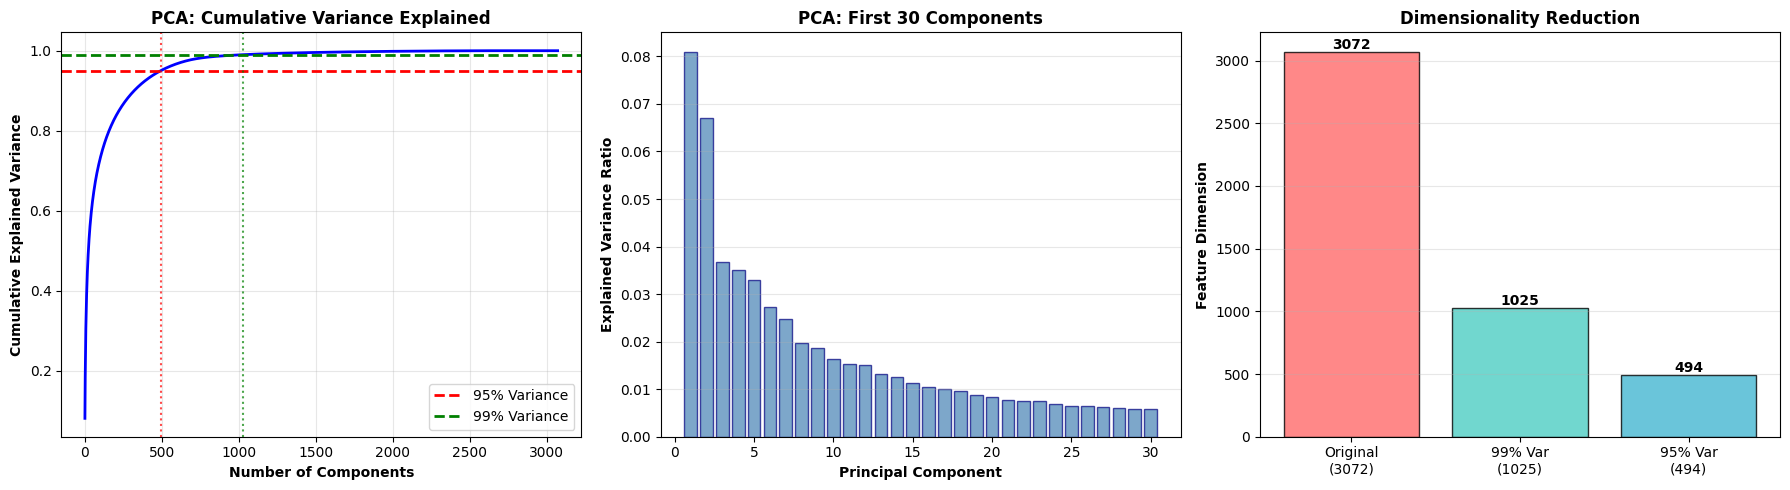


 Saved: pca_analysis.png

 Applying PCA with 494 components...
  Original shape: (13898, 3072)
  Reduced shape: (13898, 494)
  Variance retained: 0.9493
  Reduction: 83.9%
 Saved: pca_transformer.pkl


In [ ]:
print("PCA DIMENSIONALITY REDUCTION ANALYSIS")

# Analyze variance explained
pca_full = PCA()
pca_full.fit(train_features)

# Find optimal components
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"  Variance Analysis:")
print(f"  Components for 95% variance: {n_components_95} ({n_components_95/train_features.shape[1]*100:.1f}% of original)")
print(f"  Components for 99% variance: {n_components_99} ({n_components_99/train_features.shape[1]*100:.1f}% of original)")
print(f"  Original dimension: {train_features.shape[1]}")

# Visualize PCA analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cumulative variance
axes[0].plot(range(1, len(cumsum_variance)+1), cumsum_variance, 'b-', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance', linewidth=2)
axes[0].axhline(y=0.99, color='g', linestyle='--', label='99% Variance', linewidth=2)
axes[0].axvline(x=n_components_95, color='r', linestyle=':', alpha=0.7)
axes[0].axvline(x=n_components_99, color='g', linestyle=':', alpha=0.7)
axes[0].set_xlabel('Number of Components', fontweight='bold')
axes[0].set_ylabel('Cumulative Explained Variance', fontweight='bold')
axes[0].set_title('PCA: Cumulative Variance Explained', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Individual variance
axes[1].bar(range(1, 31), pca_full.explained_variance_ratio_[:30],
            color='steelblue', edgecolor='navy', alpha=0.7)
axes[1].set_xlabel('Principal Component', fontweight='bold')
axes[1].set_ylabel('Explained Variance Ratio', fontweight='bold')
axes[1].set_title('PCA: First 30 Components', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Dimensionality reduction comparison
original_dim = train_features.shape[1]
dims = [original_dim, n_components_99, n_components_95]
labels_dim = ['Original\n(3072)', f'99% Var\n({n_components_99})', f'95% Var\n({n_components_95})']

bars = axes[2].bar(labels_dim, dims, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                   edgecolor='black', alpha=0.8)
axes[2].set_ylabel('Feature Dimension', fontweight='bold')
axes[2].set_title('Dimensionality Reduction', fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Saved: pca_analysis.png")

# Apply PCA
USE_PCA = True
PCA_COMPONENTS = n_components_95

if USE_PCA:
    print(f"\n Applying PCA with {PCA_COMPONENTS} components...")
    pca = PCA(n_components=PCA_COMPONENTS)
    train_features_pca = pca.fit_transform(train_features)
    test_features_pca = pca.transform(test_features)

    print(f"  Original shape: {train_features.shape}")
    print(f"  Reduced shape: {train_features_pca.shape}")
    print(f"  Variance retained: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"  Reduction: {(1 - train_features_pca.shape[1]/train_features.shape[1])*100:.1f}%")

    # Save PCA transformer
    with open('pca_transformer.pkl', 'wb') as f:
        pickle.dump(pca, f)
    print(" Saved: pca_transformer.pkl")

    train_features_final = train_features_pca
    test_features_final = test_features_pca
else:
    train_features_final = train_features
    test_features_final = test_features
    print("\n PCA disabled - using original features")


##  **BUILD CLASSIFICATION MODEL**

In [ ]:
class SkinDiseaseClassifier(nn.Module):
    """Enhanced classifier with dropout and batch normalization"""
    def __init__(self, feature_dim, num_classes, dropout_rate=0.5):
        super(SkinDiseaseClassifier, self).__init__()
        self.feature_extractor = HybridFeatureExtractor()

        # Deep classification head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),

            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        combined_feat, resnet_feat, densenet_feat = self.feature_extractor(x)
        output = self.classifier(combined_feat)
        return output, combined_feat

# Initialize model
NUM_CLASSES = len(train_dataset.classes)
model = SkinDiseaseClassifier(
    feature_dim=feature_extractor.combined_feat_dim,
    num_classes=NUM_CLASSES,
    dropout_rate=0.5
).to(device)

# Count parameters
total_params, trainable_params = count_parameters(model)
classifier_params = total_params - hybrid_total

print(f"\nModel Architecture:")
print(f"  Feature Extractor: ResNet50 + DenseNet121")
print(f"  Classifier Layers: 4-layer deep network")
print(f"  Total Parameters: {total_params:,}")
print(f"  Feature Extractor: {hybrid_total:,}")
print(f"  Classifier Head: {classifier_params:,}")
print(f"  Trainable: {trainable_params:,}")

print(f"\nModel Summary:")
print(model)


Model Architecture:
  Feature Extractor: ResNet50 + DenseNet121
  Classifier Layers: 4-layer deep network
  Total Parameters: 39,396,822
  Feature Extractor: 30,461,888
  Classifier Head: 8,934,934
  Trainable: 39,396,822

Model Summary:
SkinDiseaseClassifier(
  (feature_extractor): HybridFeatureExtractor(
    (resnet_features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1

## **TRAIN CLASSIFICATION MODEL**

In [ ]:
print("TRAINING CLASSIFICATION MODEL")

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

NUM_EPOCHS = 30
best_val_acc = 0.0

print(f"\nTraining Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: 0.0001")
print(f"  Optimizer: AdamW")
print(f"  Loss Function: CrossEntropyLoss")
print(f"  Scheduler: ReduceLROnPlateau")

# Training loop
train_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

print(f"\n{'='*70}")
print(f"{'Epoch':>6} {'Train Loss':>12} {'Train Acc':>12} {'Val Acc':>12} {'Best':>8}")
print(f"{'='*70}")

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    # Learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Print progress
    is_best = 'best' if val_acc > best_val_acc else ''
    print(f"{epoch+1:6d} {avg_train_loss:12.4f} {train_acc:11.2f}% {val_acc:11.2f}% {is_best:>8}")

    # Learning rate scheduling
    scheduler.step(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_skin_disease_model.pth')

print(f"{'='*70}")
print(f"\n Training completed!")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"  Model saved: best_skin_disease_model.pth")

TRAINING CLASSIFICATION MODEL

Training Configuration:
  Epochs: 30
  Batch Size: 64
  Learning Rate: 0.0001
  Optimizer: AdamW
  Loss Function: CrossEntropyLoss
  Scheduler: ReduceLROnPlateau

 Epoch   Train Loss    Train Acc      Val Acc     Best
     1       2.3214       31.13%       46.57%     best
     2       1.7694       47.24%       54.01%     best
     3       1.5270       54.54%       58.15%     best
     4       1.3378       60.12%       64.17%     best
     5       1.1902       64.48%       65.65%     best
     6       1.0783       67.37%       66.88%     best
     7       0.9800       70.68%       67.66%     best
     8       0.8834       73.57%       69.21%     best
     9       0.7898       76.33%       70.83%     best
    10       0.7056       79.01%       70.25%         
    11       0.6688       79.85%       70.89%     best
    12       0.5933       81.88%       72.51%     best
    13       0.5425       83.67%       73.54%     best
    14       0.5051       84.67%    

TRAINING HISTORY VISUALIZATION


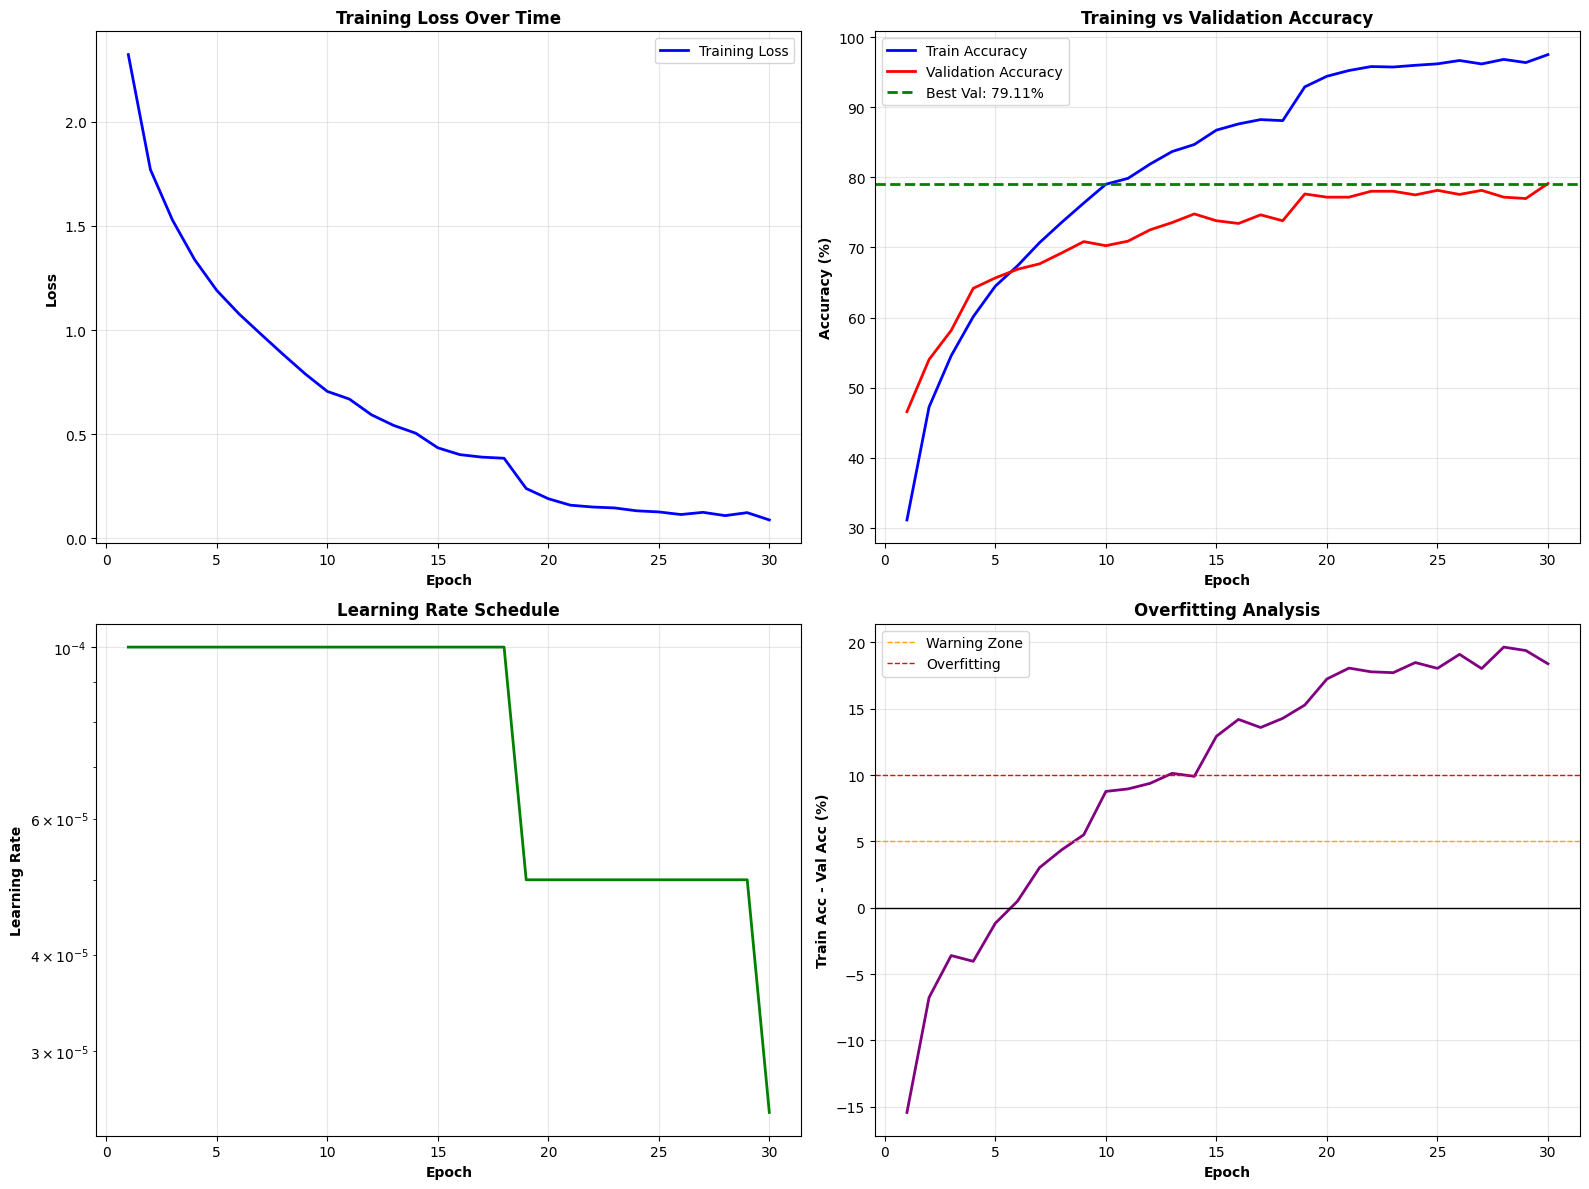

Saved: training_history.png


In [ ]:
print("TRAINING HISTORY VISUALIZATION")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss curve
axes[0, 0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', linewidth=2, label='Training Loss')
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontweight='bold')
axes[0, 0].set_title('Training Loss Over Time', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Accuracy curves
axes[0, 1].plot(range(1, NUM_EPOCHS+1), train_accuracies, 'b-', linewidth=2, label='Train Accuracy')
axes[0, 1].plot(range(1, NUM_EPOCHS+1), val_accuracies, 'r-', linewidth=2, label='Validation Accuracy')
axes[0, 1].axhline(y=best_val_acc, color='g', linestyle='--', linewidth=2,
                   label=f'Best Val: {best_val_acc:.2f}%')
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[0, 1].set_title('Training vs Validation Accuracy', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Learning rate
axes[1, 0].plot(range(1, NUM_EPOCHS+1), learning_rates, 'g-', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontweight='bold')
axes[1, 0].set_title('Learning Rate Schedule', fontweight='bold', fontsize=12)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Overfitting analysis
gap = np.array(train_accuracies) - np.array(val_accuracies)
axes[1, 1].plot(range(1, NUM_EPOCHS+1), gap, 'purple', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].axhline(y=5, color='orange', linestyle='--', linewidth=1, label='Warning Zone')
axes[1, 1].axhline(y=10, color='red', linestyle='--', linewidth=1, label='Overfitting')
axes[1, 1].set_xlabel('Epoch', fontweight='bold')
axes[1, 1].set_ylabel('Train Acc - Val Acc (%)', fontweight='bold')
axes[1, 1].set_title('Overfitting Analysis', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: training_history.png")

EVALUATE MODEL ON TEST SET

In [ ]:
print("MODEL EVALUATION ON TEST SET")
print("=" * 70)

# Load best model
model.load_state_dict(torch.load('best_skin_disease_model.pth'))
model.eval()

# Get predictions
all_preds = []
all_labels = []
all_probs = []

print("Generating predictions...")
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs, _ = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# Overall accuracy
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\n Overall Test Accuracy: {overall_acc*100:.2f}%")

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(all_labels, all_preds,
                          target_names=train_dataset.classes,
                          digits=4))

MODEL EVALUATION ON TEST SET
Generating predictions...

 Overall Test Accuracy: 79.11%

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

               Acne     0.8806    0.9077    0.8939        65
  Actinic_Keratosis     0.7471    0.7831    0.7647        83
      Benign_tumors     0.7748    0.7107    0.7414       121
            Bullous     0.7647    0.7091    0.7358        55
        Candidiasis     0.6452    0.7407    0.6897        27
       DrugEruption     0.7627    0.7377    0.7500        61
             Eczema     0.7769    0.8393    0.8069       112
 Infestations_Bites     0.6491    0.6167    0.6325        60
             Lichen     0.7547    0.6557    0.7018        61
              Lupus     0.8400    0.6176    0.7119        34
              Moles     0.6944    0.6250    0.6579        40
          Psoriasis     0.7955    0.7955    0.7955        88
            Rosacea     0.7500    0.9643    0.8438        28
  Seborrh_Keratoses     0.8367    0

CONFUSION MATRIX


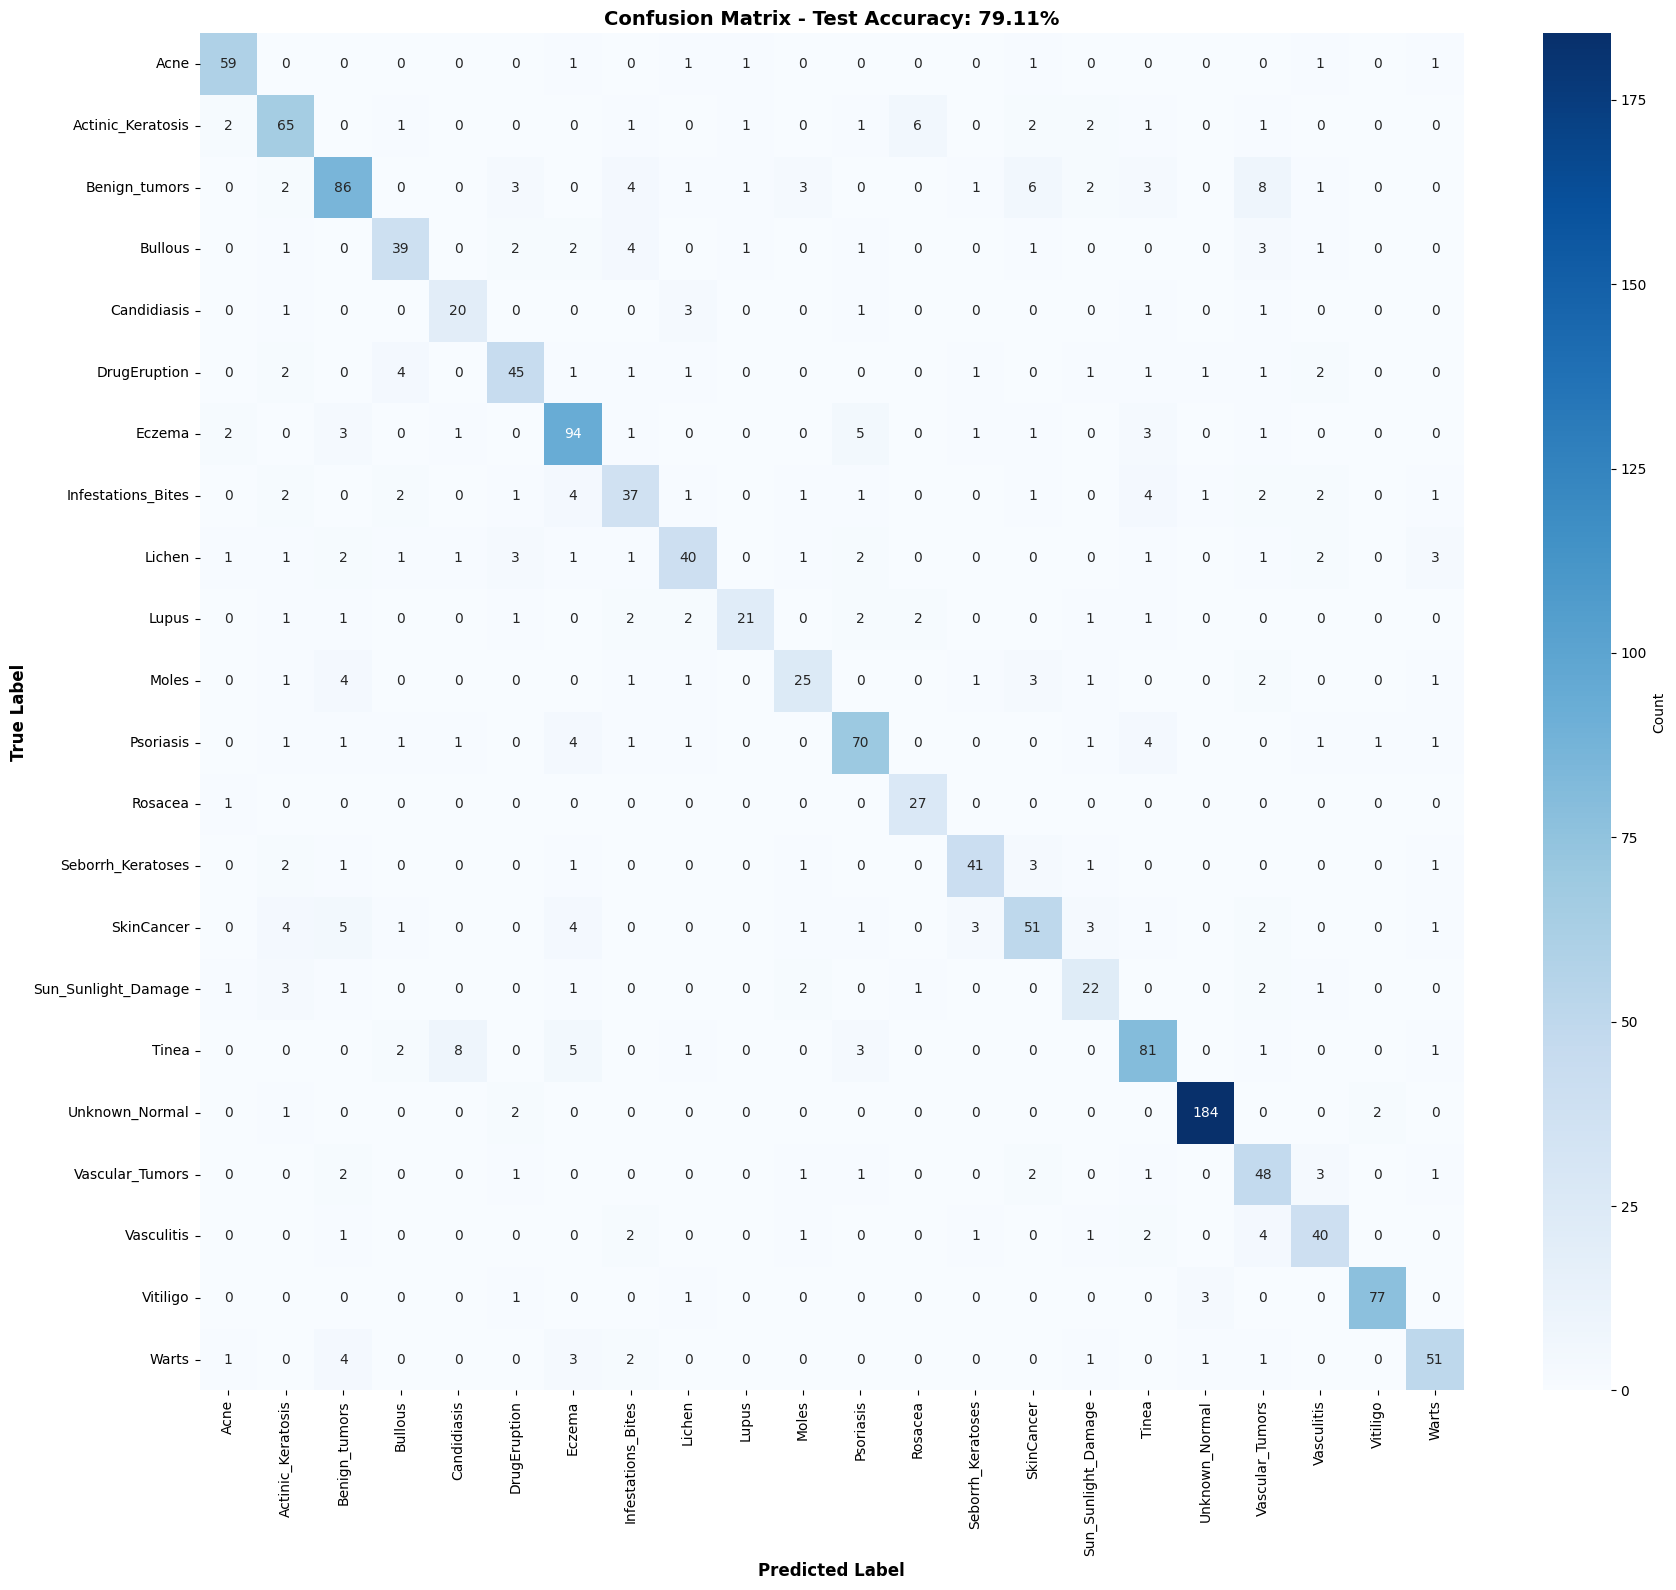

 Saved: confusion_matrix.png


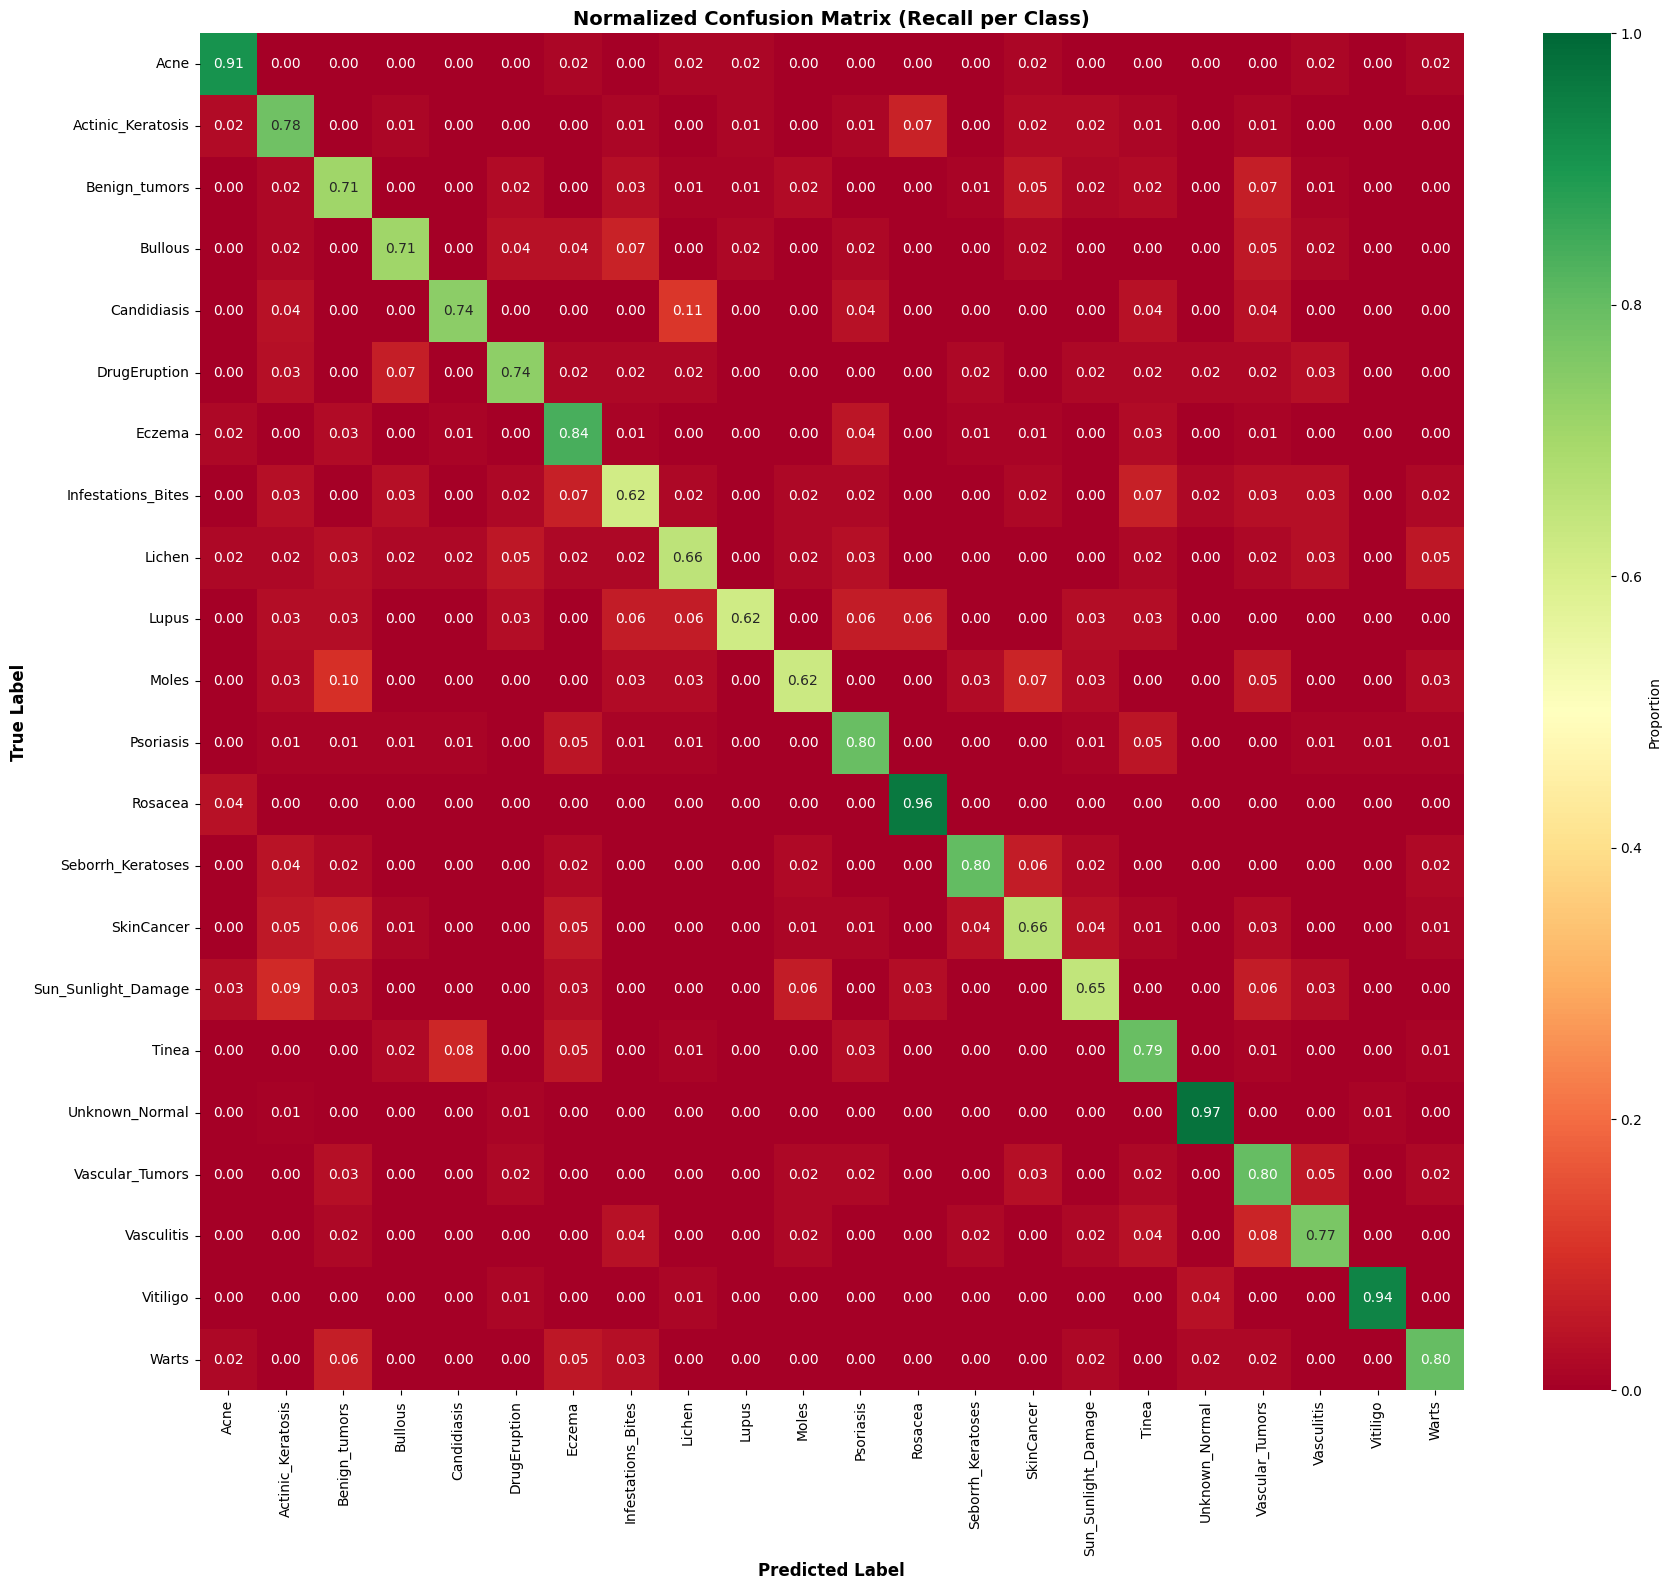

 Saved: confusion_matrix_normalized.png


In [ ]:
print("CONFUSION MATRIX")

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.title(f'Confusion Matrix - Test Accuracy: {overall_acc*100:.2f}%',
          fontweight='bold', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: confusion_matrix.png")

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(18, 16))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Label', fontweight='bold', fontsize=12)
plt.ylabel('True Label', fontweight='bold', fontsize=12)
plt.title('Normalized Confusion Matrix (Recall per Class)',
          fontweight='bold', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: confusion_matrix_normalized.png")

## **PER-CLASS ACCURACY ANALYSIS**

PER-CLASS ACCURACY ANALYSIS

              Class  Accuracy (%)  Support
     Unknown_Normal     97.354497      189
            Rosacea     96.428571       28
           Vitiligo     93.902439       82
               Acne     90.769231       65
             Eczema     83.928571      112
  Seborrh_Keratoses     80.392157       51
    Vascular_Tumors     80.000000       60
              Warts     79.687500       64
          Psoriasis     79.545455       88
              Tinea     79.411765      102
  Actinic_Keratosis     78.313253       83
         Vasculitis     76.923077       52
        Candidiasis     74.074074       27
       DrugEruption     73.770492       61
      Benign_tumors     71.074380      121
            Bullous     70.909091       55
         SkinCancer     66.233766       77
             Lichen     65.573770       61
Sun_Sunlight_Damage     64.705882       34
              Moles     62.500000       40
              Lupus     61.764706       34
 Infestations_Bites     6

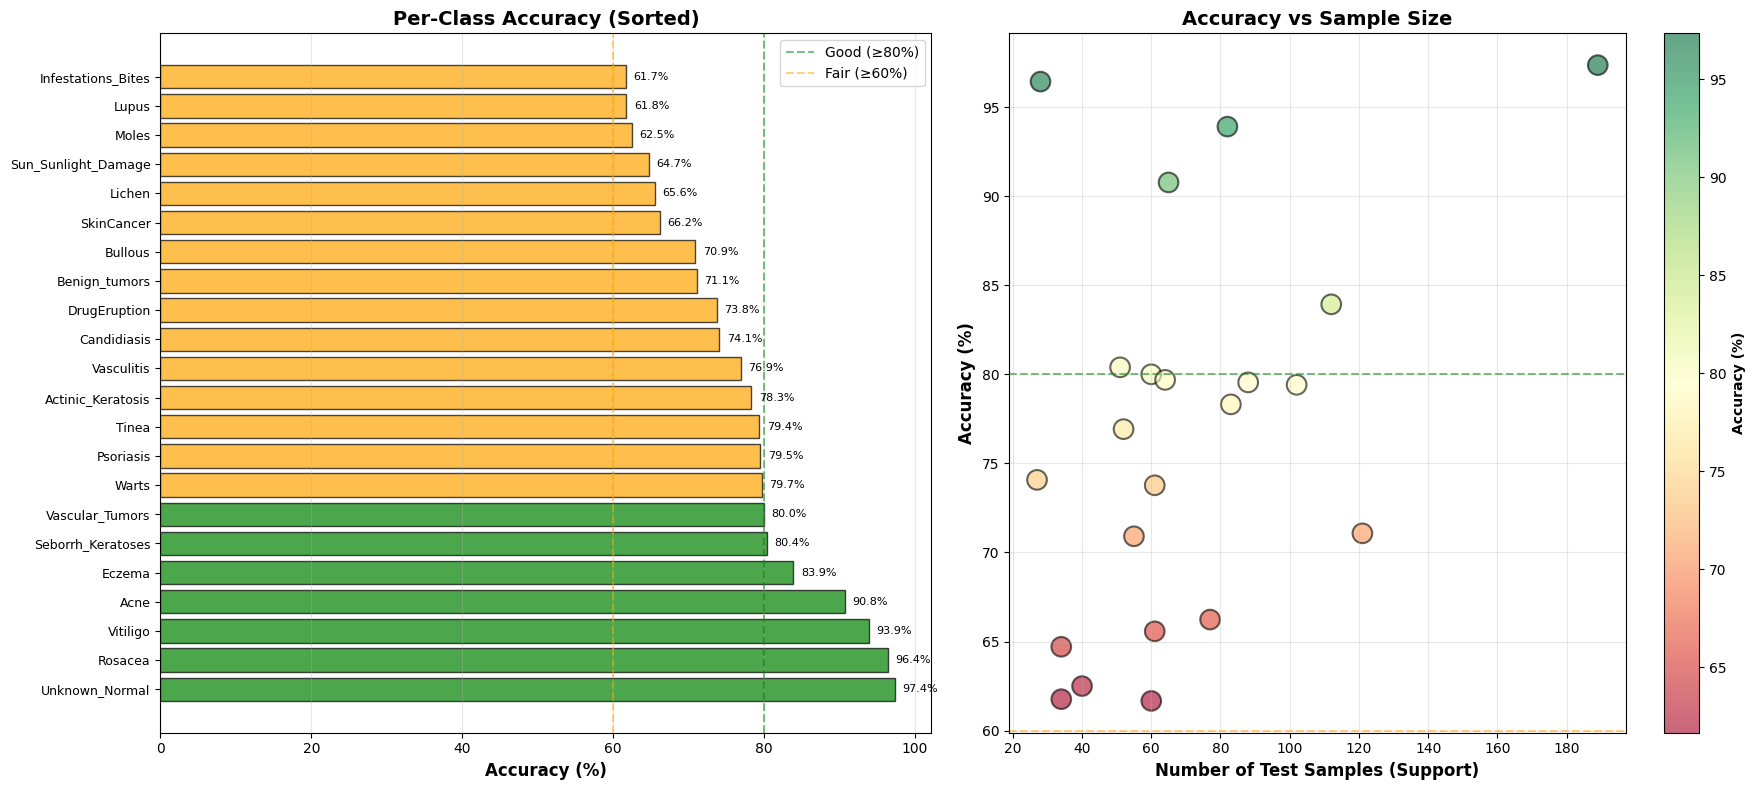


 Saved: per_class_accuracy.png


In [ ]:
print("PER-CLASS ACCURACY ANALYSIS")

# Calculate per-class metrics
class_accuracy = []
class_support = []

for i, class_name in enumerate(train_dataset.classes):
    mask = np.array(all_labels) == i
    if mask.sum() > 0:
        acc = (np.array(all_preds)[mask] == i).sum() / mask.sum()
        class_accuracy.append(acc * 100)
        class_support.append(mask.sum())
    else:
        class_accuracy.append(0)
        class_support.append(0)

# Create DataFrame
results_df = pd.DataFrame({
    'Class': train_dataset.classes,
    'Accuracy (%)': class_accuracy,
    'Support': class_support
})
results_df = results_df.sort_values('Accuracy (%)', ascending=False)

print("\n" + results_df.to_string(index=False))

# Visualize per-class accuracy
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Accuracy bar chart
sorted_classes = results_df['Class'].values
sorted_accuracy = results_df['Accuracy (%)'].values
colors = ['green' if acc >= 80 else 'orange' if acc >= 60 else 'red'
          for acc in sorted_accuracy]

axes[0].barh(range(len(sorted_classes)), sorted_accuracy, color=colors,
             edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(sorted_classes)))
axes[0].set_yticklabels(sorted_classes, fontsize=9)
axes[0].set_xlabel('Accuracy (%)', fontweight='bold', fontsize=12)
axes[0].set_title('Per-Class Accuracy (Sorted)', fontweight='bold', fontsize=14)
axes[0].axvline(x=80, color='green', linestyle='--', alpha=0.5, label='Good (≥80%)')
axes[0].axvline(x=60, color='orange', linestyle='--', alpha=0.5, label='Fair (≥60%)')
axes[0].grid(axis='x', alpha=0.3)
axes[0].legend()

# Add value labels
for i, v in enumerate(sorted_accuracy):
    axes[0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=8)

# Accuracy vs Support scatter
axes[1].scatter(class_support, class_accuracy, s=200, alpha=0.6,
                c=class_accuracy, cmap='RdYlGn', edgecolors='black', linewidth=1.5)
axes[1].set_xlabel('Number of Test Samples (Support)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Accuracy vs Sample Size', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=80, color='green', linestyle='--', alpha=0.5)
axes[1].axhline(y=60, color='orange', linestyle='--', alpha=0.5)

# Add colorbar
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Accuracy (%)', fontweight='bold')

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Saved: per_class_accuracy.png")

## **Mahalanobis Novelty detector**

In [ ]:
class MahalanobisNoveltyDetector:
    """Novelty detection using Mahalanobis distance"""
    def __init__(self):
        self.cov_estimator = EmpiricalCovariance()
        self.mean = None
        self.inv_cov = None
        self.threshold = None

    def fit(self, X, contamination=0.1):
        """Fit the detector on normal training data"""
        print("  Computing mean and covariance...")
        self.mean = np.mean(X, axis=0)
        self.cov_estimator.fit(X)
        self.inv_cov = self.cov_estimator.precision_

        distances = self.compute_distances(X)
        self.threshold = np.percentile(distances, 100 * (1 - contamination))

        return self

    def compute_distances(self, X):
        """Compute Mahalanobis distance for samples"""
        diff = X - self.mean
        distances = np.sqrt(np.sum(diff @ self.inv_cov * diff, axis=1))
        return distances

    def predict(self, X):
        """Predict novelty: 1 for novel, 0 for normal"""
        distances = self.compute_distances(X)
        predictions = (distances > self.threshold).astype(int)
        return predictions

    def score_samples(self, X):
        """Return novelty scores (distances)"""
        return self.compute_distances(X)

print("\nTraining Mahalanobis detector...")
mahalanobis_detector = MahalanobisNoveltyDetector()
mahalanobis_detector.fit(train_features_final, contamination=0.1)
print(f" Threshold: {mahalanobis_detector.threshold:.4f}")

# Test on data
train_maha_pred = mahalanobis_detector.predict(train_features_final)
test_maha_pred = mahalanobis_detector.predict(test_features_final)
train_maha_scores = mahalanobis_detector.score_samples(train_features_final)
test_maha_scores = mahalanobis_detector.score_samples(test_features_final)

print(f"\nResults:")
print(f"  Training novelty rate: {train_maha_pred.mean()*100:.2f}%")
print(f"  Testing novelty rate: {test_maha_pred.mean()*100:.2f}%")


Training Mahalanobis detector...
  Computing mean and covariance...
 Threshold: 28.1282

Results:
  Training novelty rate: 10.00%
  Testing novelty rate: 19.99%


## **NOVELTY DETECTION - ONE-CLASS SVM**

In [ ]:
print("\nTraining One-Class SVM...")
ocsvm_detector = OneClassSVM(kernel='rbf', nu=0.1, gamma='auto')
ocsvm_detector.fit(train_features_final)
print("Training complete")

# Predictions: -1 for outliers, 1 for inliers
train_ocsvm_pred = ocsvm_detector.predict(train_features_final)
train_ocsvm_pred = (train_ocsvm_pred == -1).astype(int)
test_ocsvm_pred = ocsvm_detector.predict(test_features_final)
test_ocsvm_pred = (test_ocsvm_pred == -1).astype(int)

print(f"\nResults:")
print(f"  Training novelty rate: {train_ocsvm_pred.mean()*100:.2f}%")
print(f"  Testing novelty rate: {test_ocsvm_pred.mean()*100:.2f}%")


Training One-Class SVM...
Training complete

Results:
  Training novelty rate: 9.99%
  Testing novelty rate: 46.77%


## **NOVELTY DETECTION - DEEP SVDD**

In [ ]:
class DeepSVDD:
    """Simplified Deep Support Vector Data Description"""
    def __init__(self, nu=0.1):
        self.nu = nu
        self.center = None
        self.radius = None

    def fit(self, X):
        """Fit the hypersphere"""
        print("  Computing hypersphere center...")
        self.center = np.mean(X, axis=0)

        distances = np.linalg.norm(X - self.center, axis=1)
        self.radius = np.percentile(distances, 100 * (1 - self.nu))

        return self

    def predict(self, X):
        """Predict novelty: 1 for novel, 0 for normal"""
        distances = np.linalg.norm(X - self.center, axis=1)
        predictions = (distances > self.radius).astype(int)
        return predictions

    def score_samples(self, X):
        """Return novelty scores (distances from center)"""
        return np.linalg.norm(X - self.center, axis=1)

print("\nTraining Deep SVDD...")
deep_svdd = DeepSVDD(nu=0.1)
deep_svdd.fit(train_features_final)
print(f" Hypersphere radius: {deep_svdd.radius:.4f}")

train_svdd_pred = deep_svdd.predict(train_features_final)
test_svdd_pred = deep_svdd.predict(test_features_final)

print(f"\nResults:")
print(f"  Training novelty rate: {train_svdd_pred.mean()*100:.2f}%")
print(f"  Testing novelty rate: {test_svdd_pred.mean()*100:.2f}%")


Training Deep SVDD...
  Computing hypersphere center...
 Hypersphere radius: 31.0492

Results:
  Training novelty rate: 10.00%
  Testing novelty rate: 26.91%


## **ENSEMBLE NOVELTY DETECTION**

In [ ]:
def ensemble_novelty_detection(maha_scores, ocsvm_pred, svdd_pred,
                                weights=[0.5, 0.25, 0.25]):
    """Combine predictions from multiple novelty detectors"""
    # Normalize Mahalanobis scores to [0, 1]
    maha_norm = (maha_scores - maha_scores.min()) / (maha_scores.max() - maha_scores.min() + 1e-8)

    # Ensemble score
    ensemble_score = (weights[0] * maha_norm +
                      weights[1] * ocsvm_pred +
                      weights[2] * svdd_pred)

    # Threshold at 0.5
    ensemble_pred = (ensemble_score > 0.5).astype(int)

    return ensemble_pred, ensemble_score

print("\nCombining detector predictions...")
train_ensemble_pred, train_ensemble_scores = ensemble_novelty_detection(
    train_maha_scores, train_ocsvm_pred, train_svdd_pred
)
test_ensemble_pred, test_ensemble_scores = ensemble_novelty_detection(
    test_maha_scores, test_ocsvm_pred, test_svdd_pred
)

print(f"\nResults:")
print(f"  Training novelty rate: {train_ensemble_pred.mean()*100:.2f}%")
print(f"  Testing novelty rate: {test_ensemble_pred.mean()*100:.2f}%")



Combining detector predictions...

Results:
  Training novelty rate: 8.30%
  Testing novelty rate: 26.33%


NOVELTY DETECTION VISUALIZATION


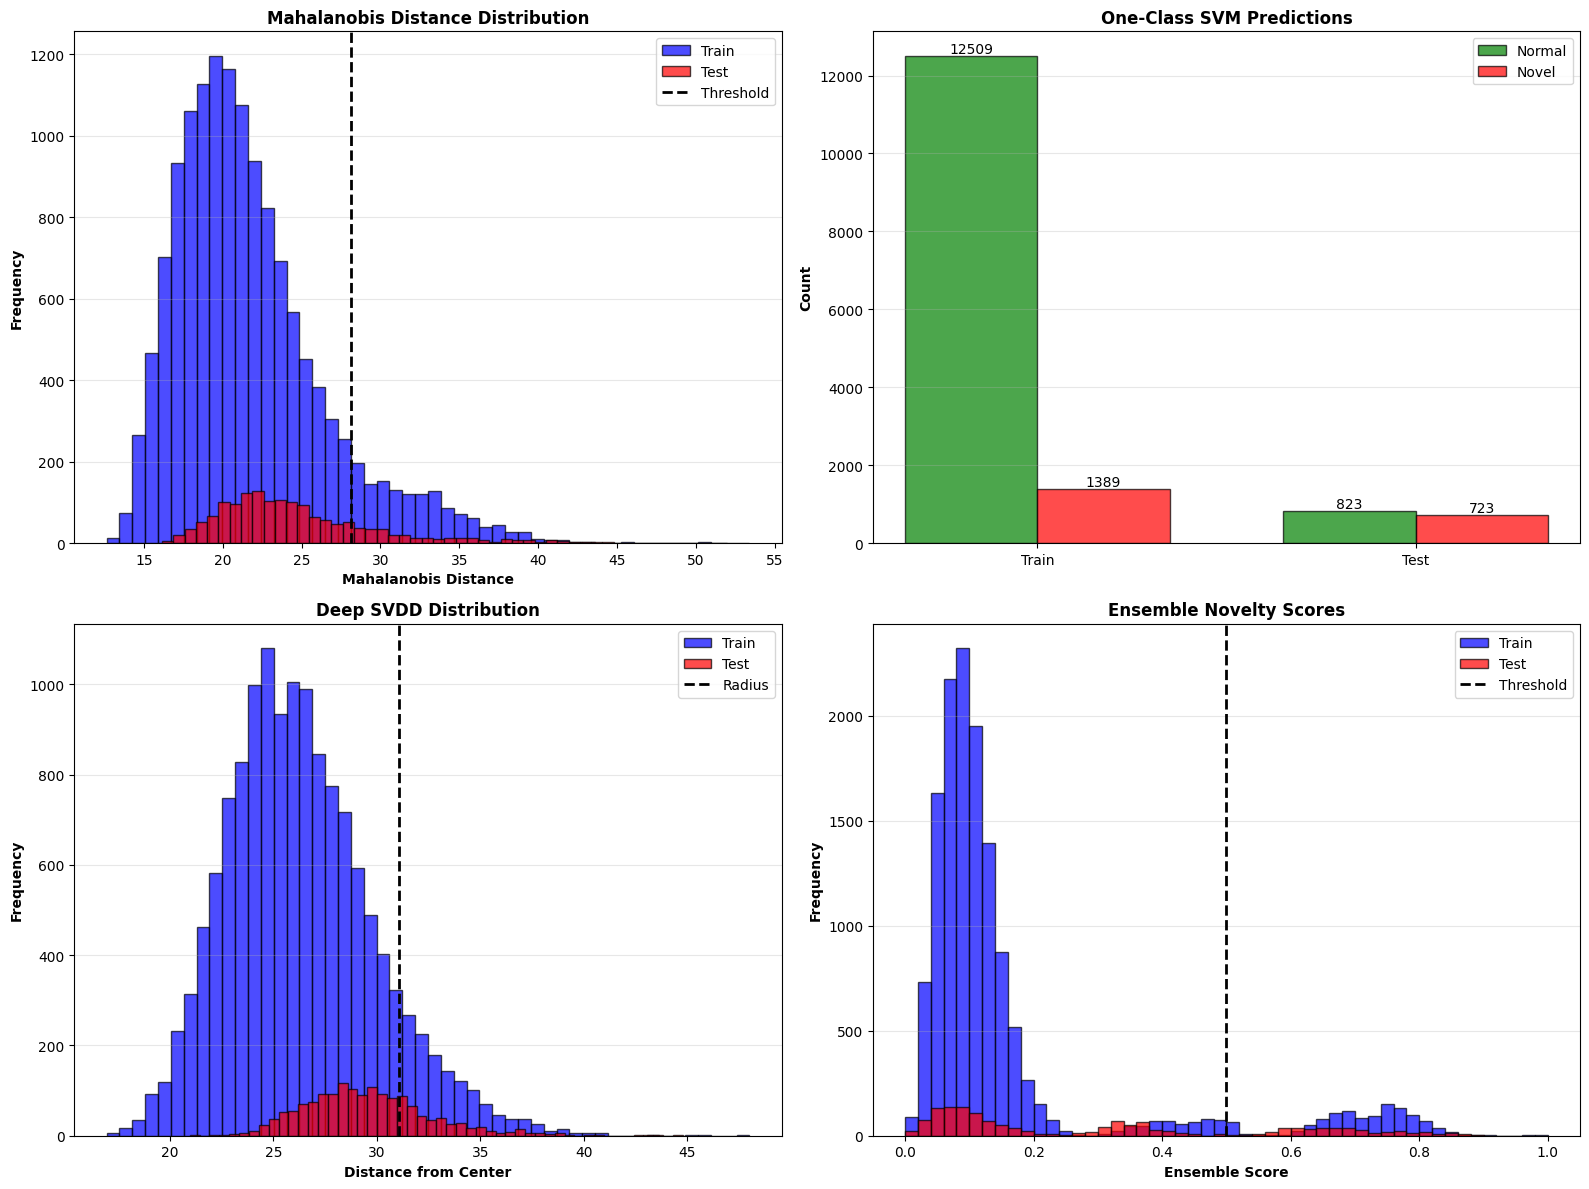

 Saved: novelty_detection_results.png


In [ ]:
print("NOVELTY DETECTION VISUALIZATION")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mahalanobis Distribution
axes[0, 0].hist(train_maha_scores, bins=50, alpha=0.7, label='Train',
                color='blue', edgecolor='black')
axes[0, 0].hist(test_maha_scores, bins=50, alpha=0.7, label='Test',
                color='red', edgecolor='black')
axes[0, 0].axvline(mahalanobis_detector.threshold, color='black',
                   linestyle='--', linewidth=2, label='Threshold')
axes[0, 0].set_xlabel('Mahalanobis Distance', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Mahalanobis Distance Distribution', fontweight='bold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# One-Class SVM
methods = ['Train', 'Test']
normal = [len(train_ocsvm_pred) - train_ocsvm_pred.sum(),
          len(test_ocsvm_pred) - test_ocsvm_pred.sum()]
novel = [train_ocsvm_pred.sum(), test_ocsvm_pred.sum()]

x = np.arange(len(methods))
width = 0.35

bars1 = axes[0, 1].bar(x - width/2, normal, width, label='Normal',
                       color='green', edgecolor='black', alpha=0.7)
bars2 = axes[0, 1].bar(x + width/2, novel, width, label='Novel',
                       color='red', edgecolor='black', alpha=0.7)
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].set_title('One-Class SVM Predictions', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(methods)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=10)

# Deep SVDD Distribution
train_svdd_scores = deep_svdd.score_samples(train_features_final)
test_svdd_scores = deep_svdd.score_samples(test_features_final)

axes[1, 0].hist(train_svdd_scores, bins=50, alpha=0.7, label='Train',
                color='blue', edgecolor='black')
axes[1, 0].hist(test_svdd_scores, bins=50, alpha=0.7, label='Test',
                color='red', edgecolor='black')
axes[1, 0].axvline(deep_svdd.radius, color='black', linestyle='--',
                   linewidth=2, label='Radius')
axes[1, 0].set_xlabel('Distance from Center', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Deep SVDD Distribution', fontweight='bold', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Ensemble Scores
axes[1, 1].hist(train_ensemble_scores, bins=50, alpha=0.7, label='Train',
                color='blue', edgecolor='black')
axes[1, 1].hist(test_ensemble_scores, bins=50, alpha=0.7, label='Test',
                color='red', edgecolor='black')
axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold')
axes[1, 1].set_xlabel('Ensemble Score', fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontweight='bold')
axes[1, 1].set_title('Ensemble Novelty Scores', fontweight='bold', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('novelty_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: novelty_detection_results.png")

## **NOVELTY DETECTION COMPARISON TABLE**


       Method  Train Novelty (%)  Test Novelty (%)
  Mahalanobis          10.001439         19.987063
One-Class SVM           9.994244         46.765847
    Deep SVDD          10.001439         26.908150
     Ensemble           8.303353         26.326003


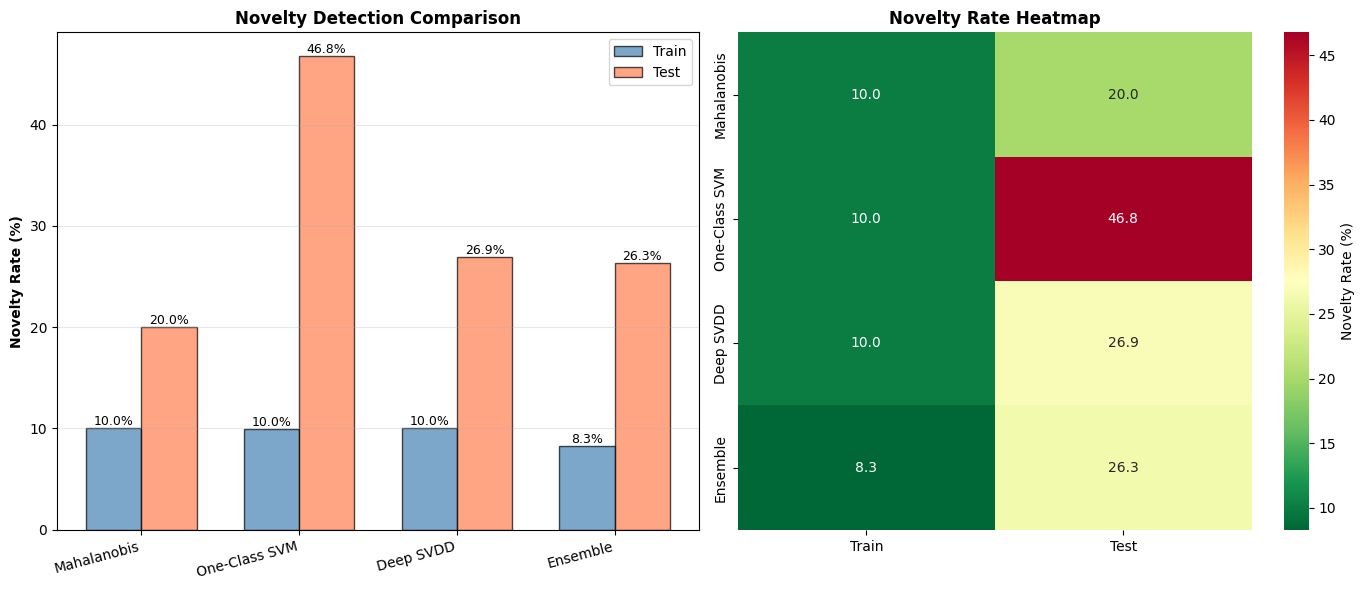

Saved: novelty_comparison.png


In [ ]:
comparison_df = pd.DataFrame({
    'Method': ['Mahalanobis', 'One-Class SVM', 'Deep SVDD', 'Ensemble'],
    'Train Novelty (%)': [
        train_maha_pred.mean()*100,
        train_ocsvm_pred.mean()*100,
        train_svdd_pred.mean()*100,
        train_ensemble_pred.mean()*100
    ],
    'Test Novelty (%)': [
        test_maha_pred.mean()*100,
        test_ocsvm_pred.mean()*100,
        test_svdd_pred.mean()*100,
        test_ensemble_pred.mean()*100
    ]
})

print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
methods = comparison_df['Method']
train_nov = comparison_df['Train Novelty (%)']
test_nov = comparison_df['Test Novelty (%)']

x = np.arange(len(methods))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_nov, width, label='Train',
                    color='steelblue', edgecolor='black', alpha=0.7)
bars2 = axes[0].bar(x + width/2, test_nov, width, label='Test',
                    color='coral', edgecolor='black', alpha=0.7)

axes[0].set_ylabel('Novelty Rate (%)', fontweight='bold')
axes[0].set_title('Novelty Detection Comparison', fontweight='bold', fontsize=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.1f}%',
                     ha='center', va='bottom', fontsize=9)

# Heatmap
data = np.array([train_nov, test_nov]).T
sns.heatmap(data, annot=True, fmt='.1f', cmap='RdYlGn_r',
            xticklabels=['Train', 'Test'],
            yticklabels=methods,
            cbar_kws={'label': 'Novelty Rate (%)'},
            ax=axes[1])
axes[1].set_title('Novelty Rate Heatmap', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('novelty_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: novelty_comparison.png")

## **GRAD-CAM VISUALIZATION**

GRAD-CAM VISUALIZATION


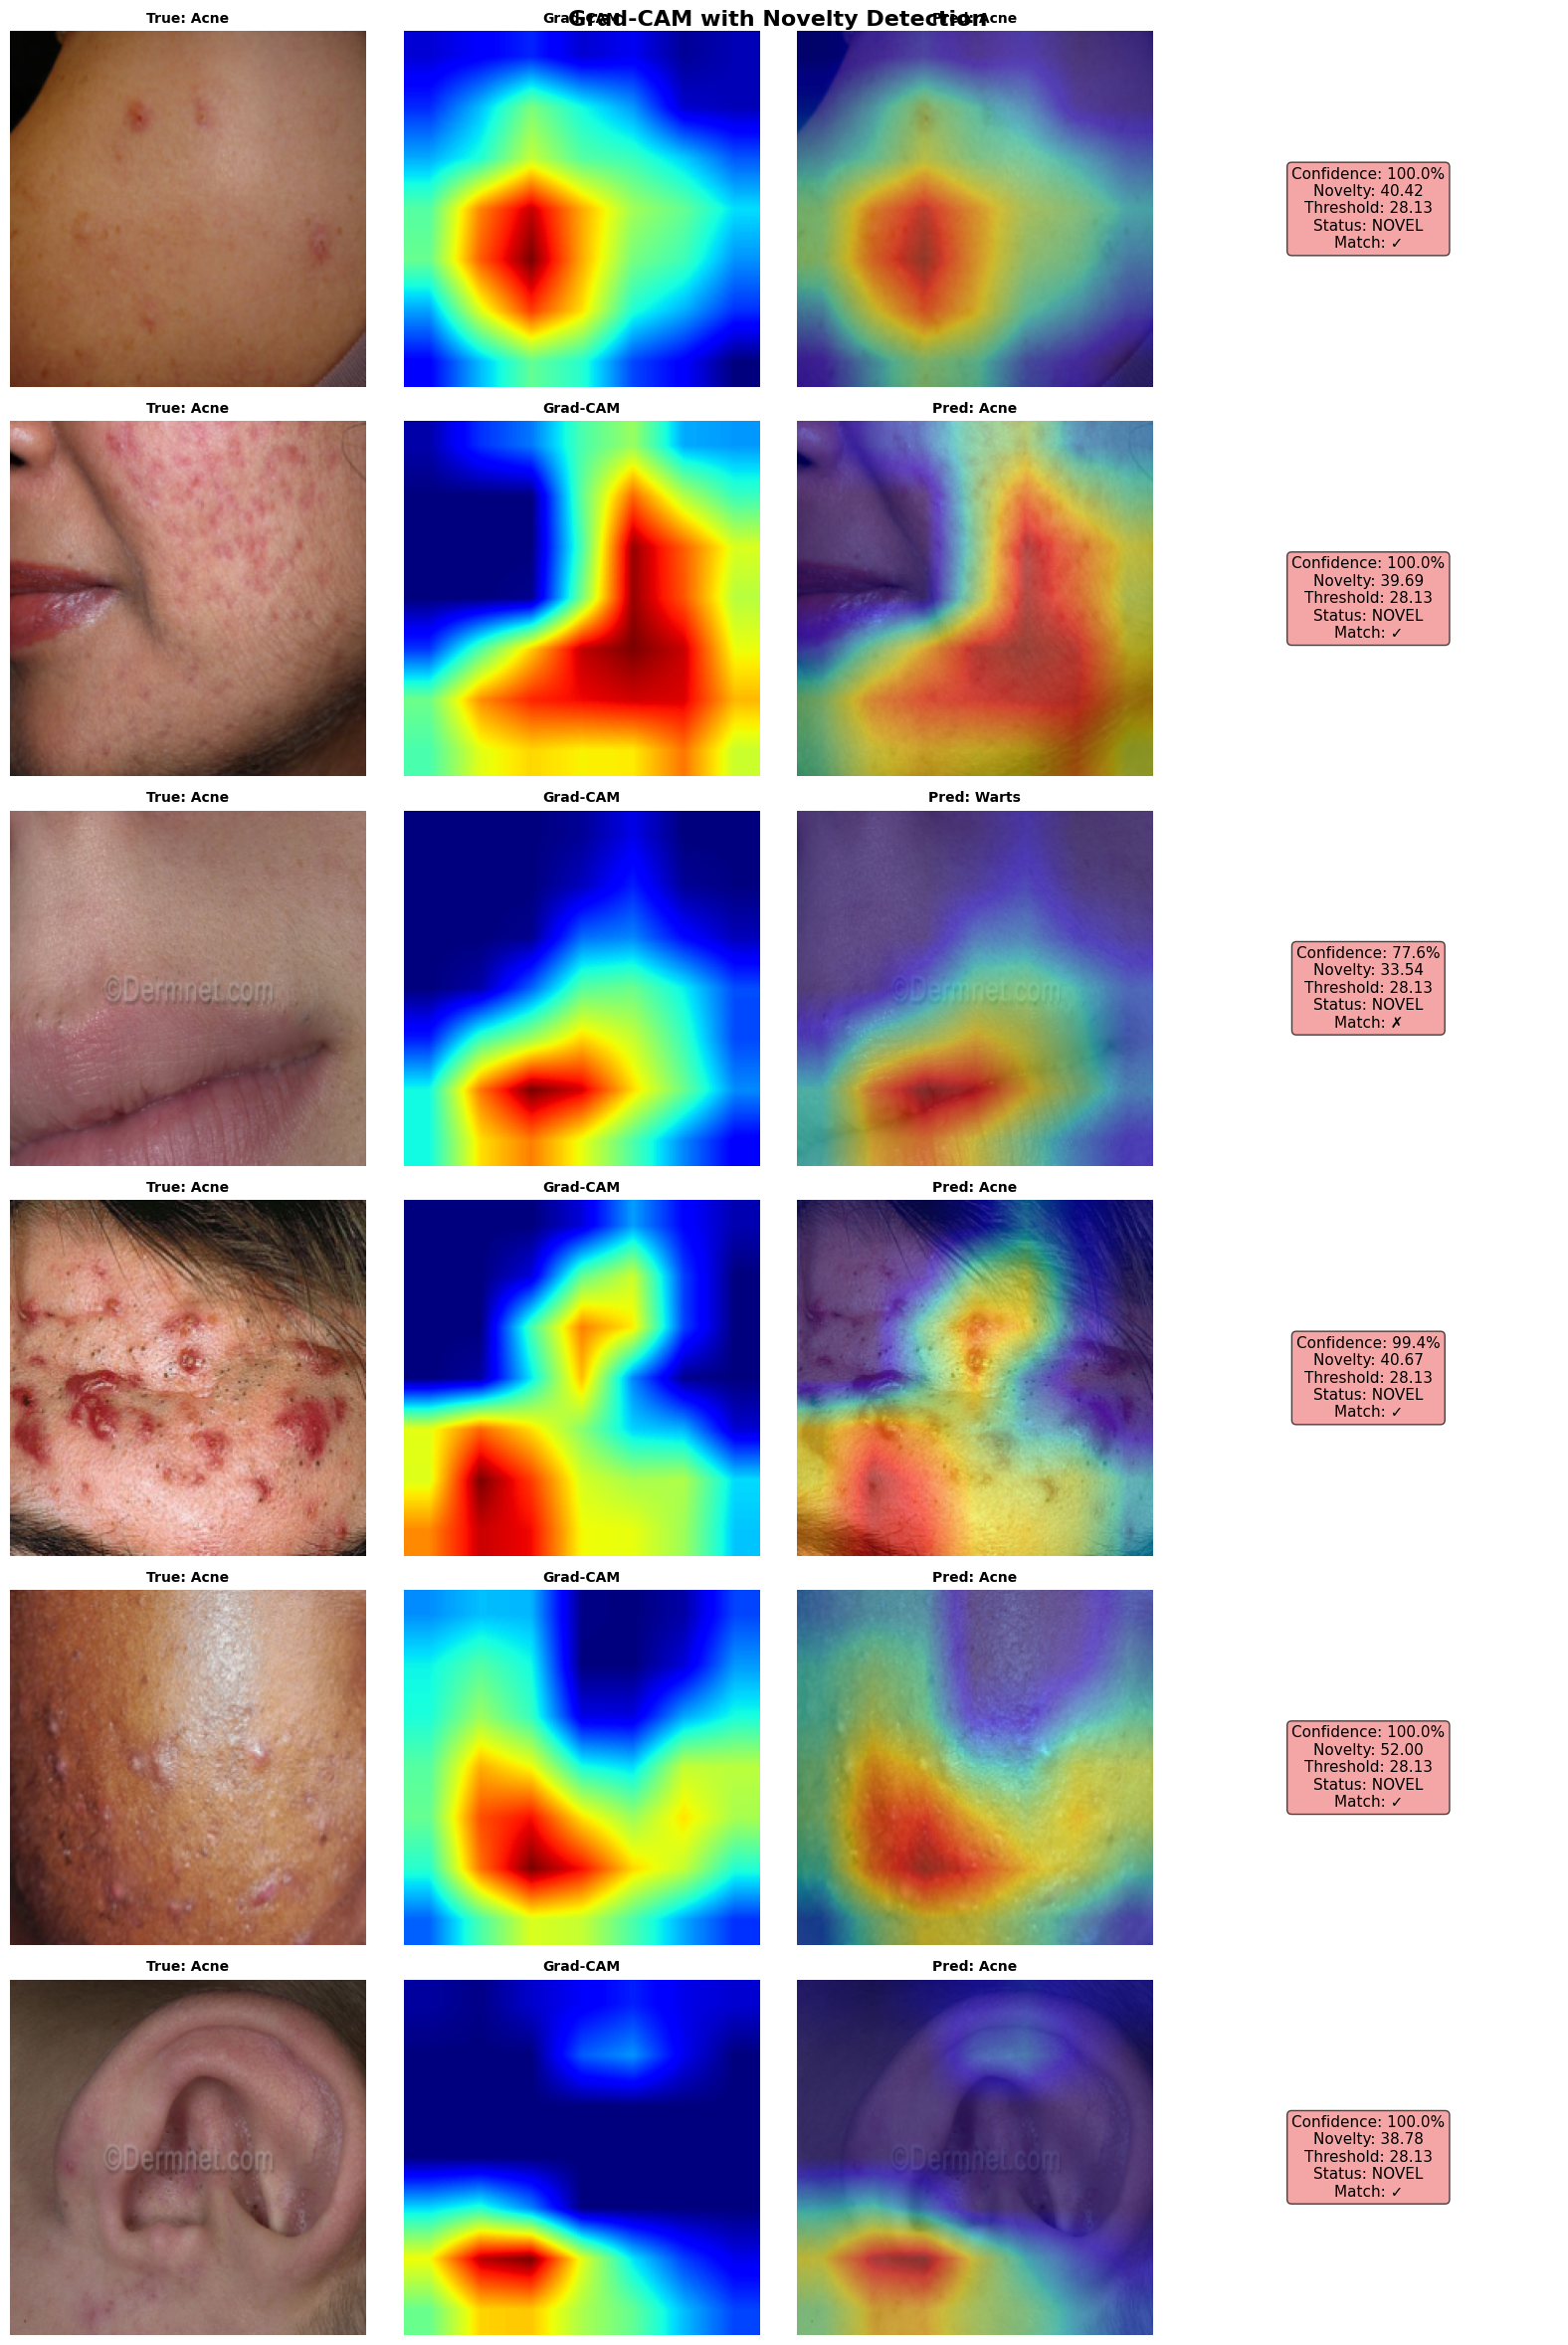

 Saved: gradcam_with_novelty.png


In [ ]:
print("GRAD-CAM VISUALIZATION")

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.forward_hook = target_layer.register_forward_hook(self.save_activation)
        self.backward_hook = target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class):
        self.model.eval()
        output, _ = self.model(input_image)
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward(retain_graph=True)

        gradients = self.gradients[0]
        activations = self.activations[0]
        weights = gradients.mean(dim=(1, 2), keepdim=True)
        cam = (weights * activations).sum(dim=0)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.cpu().numpy()

    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

def visualize_gradcam_novelty(model, test_loader, detector, class_names,
                               num_samples=6, use_pca=USE_PCA, pca_transformer=None):
    gradcam = GradCAM(model, model.feature_extractor.densenet_last_conv)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, num_samples * 4))

    for i in range(min(num_samples, len(images))):
        img = images[i:i+1].to(device)
        img.requires_grad = True

        output, features = model(img)
        probs = torch.softmax(output, dim=1)
        pred_class = probs.argmax().item()
        confidence = probs.max().item()

        # Apply PCA if needed
        features_np = features.detach().cpu().numpy()
        if use_pca and pca_transformer is not None:
            features_np = pca_transformer.transform(features_np)

        novelty_score = detector.score_samples(features_np)
        is_novel = detector.predict(features_np)

        cam = gradcam.generate_cam(img, pred_class)

        img_np = images[i].cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        cam_resized = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))

        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title(f'True: {class_names[labels[i]][:15]}',
                            fontsize=10, fontweight='bold')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(cam_resized, cmap='jet')
        axes[i, 1].set_title('Grad-CAM', fontsize=10, fontweight='bold')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(img_np)
        axes[i, 2].imshow(cam_resized, cmap='jet', alpha=0.5)
        axes[i, 2].set_title(f'Pred: {class_names[pred_class][:15]}',
                            fontsize=10, fontweight='bold')
        axes[i, 2].axis('off')

        axes[i, 3].axis('off')
        novelty_text = f"Confidence: {confidence*100:.1f}%\n"
        novelty_text += f"Novelty: {novelty_score[0]:.2f}\n"
        novelty_text += f"Threshold: {detector.threshold:.2f}\n"
        novelty_text += f"Status: {'NOVEL' if is_novel[0] else 'NORMAL'}\n"
        novelty_text += f"Match: {'✓' if pred_class == labels[i] else '✗'}"

        color = 'lightcoral' if is_novel[0] else 'lightgreen'
        axes[i, 3].text(0.5, 0.5, novelty_text, ha='center', va='center',
                        fontsize=11, bbox=dict(boxstyle='round', facecolor=color,
                        alpha=0.7, edgecolor='black'))

    plt.suptitle('Grad-CAM with Novelty Detection', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gradcam_with_novelty.png', dpi=300, bbox_inches='tight')
    plt.show()
    gradcam.remove_hooks()

if USE_PCA:
    visualize_gradcam_novelty(model, test_loader, mahalanobis_detector,
                              train_dataset.classes, num_samples=6,
                              use_pca=True, pca_transformer=pca)
else:
    visualize_gradcam_novelty(model, test_loader, mahalanobis_detector,
                              train_dataset.classes, num_samples=6,
                              use_pca=False, pca_transformer=None)
print(" Saved: gradcam_with_novelty.png")


## **PREDICTION CONFIDENCE ANALYSIS**


Confidence Statistics:
  Correct Predictions:
    Mean: 95.77%
    Median: 99.91%
    Std: 11.29%

  Incorrect Predictions:
    Mean: 77.46%
    Median: 82.81%
    Std: 20.37%


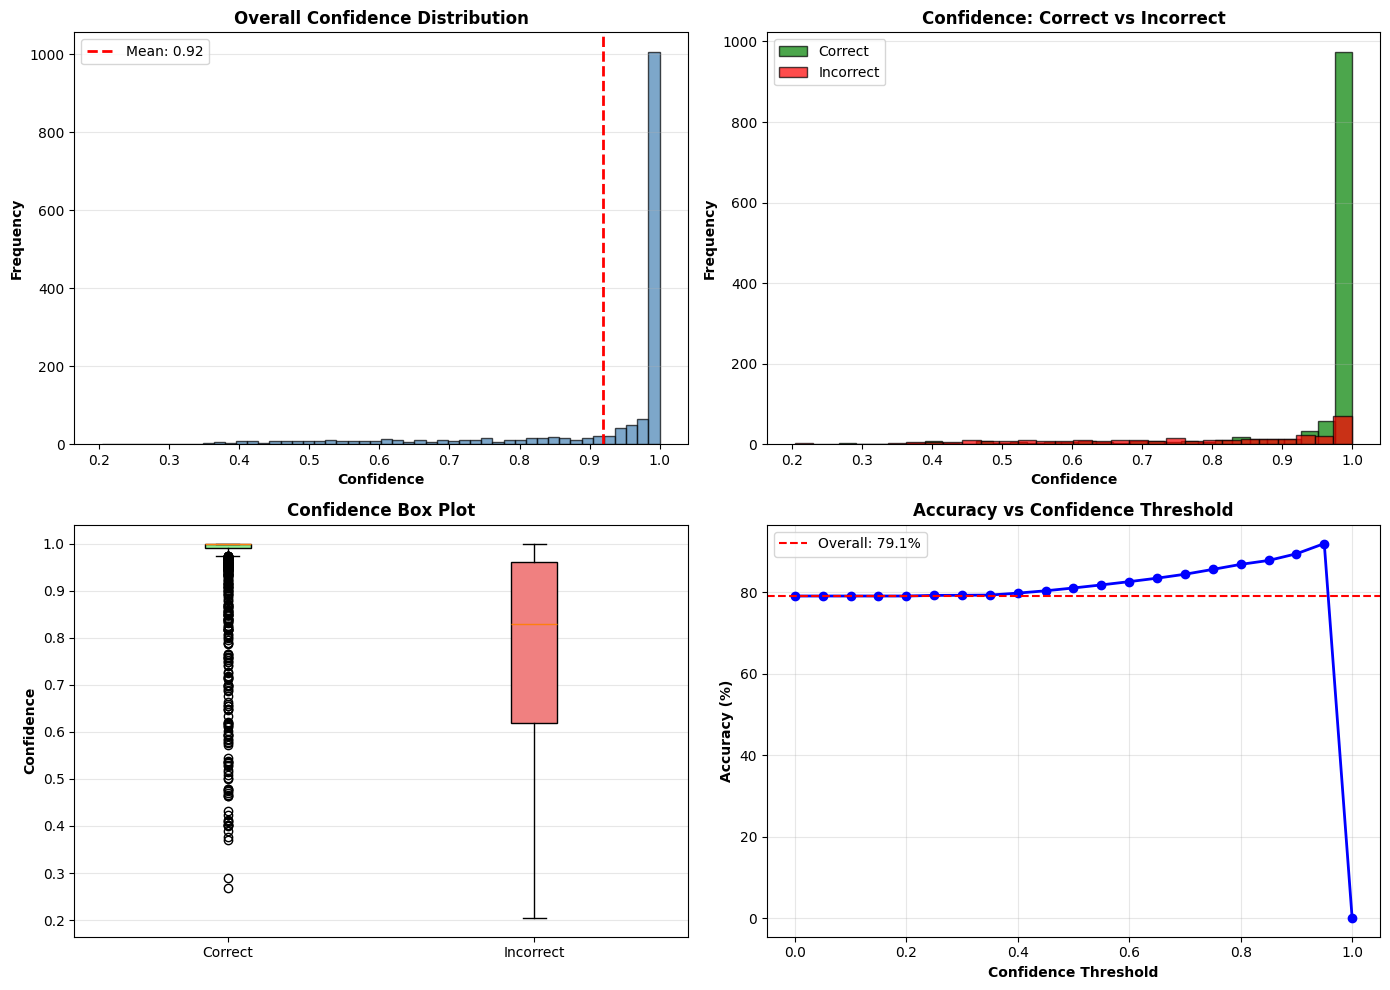

 Saved: confidence_analysis.png


In [ ]:
# Extract prediction confidences
all_probs_array = np.array(all_probs)
max_probs = all_probs_array.max(axis=1)
correct_mask = np.array(all_preds) == np.array(all_labels)

correct_probs = max_probs[correct_mask]
incorrect_probs = max_probs[~correct_mask]

print(f"\nConfidence Statistics:")
print(f"  Correct Predictions:")
print(f"    Mean: {correct_probs.mean()*100:.2f}%")
print(f"    Median: {np.median(correct_probs)*100:.2f}%")
print(f"    Std: {correct_probs.std()*100:.2f}%")
print(f"\n  Incorrect Predictions:")
print(f"    Mean: {incorrect_probs.mean()*100:.2f}%")
print(f"    Median: {np.median(incorrect_probs)*100:.2f}%")
print(f"    Std: {incorrect_probs.std()*100:.2f}%")

# Visualize confidence distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of all confidences
axes[0, 0].hist(max_probs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Confidence', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('Overall Confidence Distribution', fontweight='bold')
axes[0, 0].axvline(max_probs.mean(), color='red', linestyle='--',
                   linewidth=2, label=f'Mean: {max_probs.mean():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Correct vs Incorrect
axes[0, 1].hist(correct_probs, bins=30, alpha=0.7, label='Correct',
                color='green', edgecolor='black')
axes[0, 1].hist(incorrect_probs, bins=30, alpha=0.7, label='Incorrect',
                color='red', edgecolor='black')
axes[0, 1].set_xlabel('Confidence', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Confidence: Correct vs Incorrect', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Box plot
data_box = [correct_probs, incorrect_probs]
bp = axes[1, 0].boxplot(data_box, labels=['Correct', 'Incorrect'],
                        patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1, 0].set_ylabel('Confidence', fontweight='bold')
axes[1, 0].set_title('Confidence Box Plot', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Confidence vs Accuracy curve
thresholds = np.arange(0, 1.01, 0.05)
accuracies_at_threshold = []
samples_at_threshold = []

for thresh in thresholds:
    mask = max_probs >= thresh
    if mask.sum() > 0:
        acc = (np.array(all_preds)[mask] == np.array(all_labels)[mask]).mean()
        accuracies_at_threshold.append(acc * 100)
        samples_at_threshold.append(mask.sum())
    else:
        accuracies_at_threshold.append(0)
        samples_at_threshold.append(0)

axes[1, 1].plot(thresholds, accuracies_at_threshold, 'b-', linewidth=2, marker='o')
axes[1, 1].set_xlabel('Confidence Threshold', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[1, 1].set_title('Accuracy vs Confidence Threshold', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=overall_acc*100, color='red', linestyle='--',
                   label=f'Overall: {overall_acc*100:.1f}%')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: confidence_analysis.png")

## **SAVE ALL MODELS AND DETECTORS**

In [ ]:
print("SAVING MODELS AND DETECTORS")

# Save feature extractor
torch.save(feature_extractor.state_dict(), 'hybrid_feature_extractor.pth')
print("Saved: hybrid_feature_extractor.pth")

# Save classification model (already saved as best model)
print(" Already saved: best_skin_disease_model.pth")

# Save novelty detectors
with open('mahalanobis_detector.pkl', 'wb') as f:
    pickle.dump(mahalanobis_detector, f)
print(" Saved: mahalanobis_detector.pkl")

with open('ocsvm_detector.pkl', 'wb') as f:
    pickle.dump(ocsvm_detector, f)
print(" Saved: ocsvm_detector.pkl")

with open('deep_svdd_detector.pkl', 'wb') as f:
    pickle.dump(deep_svdd, f)
print(" Saved: deep_svdd_detector.pkl")

# Save class names
with open('class_names.pkl', 'wb') as f:
    pickle.dump(train_dataset.classes, f)
print(" Saved: class_names.pkl")

if USE_PCA:
    print(" Already saved: pca_transformer.pkl")

SAVING MODELS AND DETECTORS
Saved: hybrid_feature_extractor.pth
 Already saved: best_skin_disease_model.pth
 Saved: mahalanobis_detector.pkl
 Saved: ocsvm_detector.pkl
 Saved: deep_svdd_detector.pkl
 Saved: class_names.pkl
 Already saved: pca_transformer.pkl


## **MODEL INFERENCE EXAMPLE**

In [ ]:
print("\n" + "="*70)
print("INFERENCE EXAMPLE")
print("="*70)

def predict_image(image_path, model, detector, class_names, transform,
                  use_pca=USE_PCA, pca_transformer=None):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output, features = model(image_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = probs.argmax().item()
        confidence = probs.max().item()

    features_np = features.cpu().numpy()
    if use_pca and pca_transformer is not None:
        features_np = pca_transformer.transform(features_np)

    novelty_score = detector.score_samples(features_np)[0]
    is_novel = novelty_score > detector.threshold

    result = {
        'predicted_class': class_names[pred_class],
        'confidence': confidence * 100,
        'novelty_score': novelty_score,
        'is_novel': is_novel,
        'top_3_predictions': []
    }

    top3_probs, top3_indices = torch.topk(probs, 3)
    for prob, idx in zip(top3_probs[0], top3_indices[0]):
        result['top_3_predictions'].append({
            'class': class_names[idx.item()],
            'confidence': prob.item() * 100
        })

    return result

# Test
test_image_path = test_dataset.images[0]
if USE_PCA:
    result = predict_image(test_image_path, model, mahalanobis_detector,
                          train_dataset.classes, test_transform,
                          use_pca=True, pca_transformer=pca)
else:
    result = predict_image(test_image_path, model, mahalanobis_detector,
                          train_dataset.classes, test_transform,
                          use_pca=False, pca_transformer=None)

print(f"\nSample Prediction:")
print(f"  Image: {os.path.basename(test_image_path)}")
print(f"  Predicted: {result['predicted_class']}")
print(f"  Confidence: {result['confidence']:.2f}%")
print(f"  Novelty Score: {result['novelty_score']:.4f}")
print(f"  Status: {'NOVEL' if result['is_novel'] else 'NORMAL'}")
print(f"\n  Top 3:")
for i, pred in enumerate(result['top_3_predictions'], 1):
    print(f"    {i}. {pred['class']:30s} - {pred['confidence']:.2f}%")



INFERENCE EXAMPLE

Sample Prediction:
  Image: 157__ProtectWyJQcm90ZWN0Il0_FocusFillWzI5NCwyMjIsIngiLDFd.jpeg
  Predicted: Acne
  Confidence: 99.95%
  Novelty Score: 40.4190
  Status: NOVEL

  Top 3:
    1. Acne                           - 99.95%
    2. Infestations_Bites             - 0.04%
    3. Rosacea                        - 0.00%


## **FINAL SUMMARY AND STATISTICS**

In [ ]:
print("FINAL SUMMARY...")
print(f"DATASET STATISTICS..")
print(f"{'='*70}")
print(f"  Total Classes: {NUM_CLASSES}")
print(f"  Training Samples: {len(train_dataset)}")
print(f"  Testing Samples: {len(test_dataset)}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")


print(f"\n MODEL ARCHITECTURE")
print(f"  Feature Extractor: ResNet50 + DenseNet121")
print(f"  Total Parameters: {total_params:,}")
print(f"  Feature Dimension: {feature_extractor.combined_feat_dim}")
if USE_PCA:
    print(f"  PCA Reduced Dimension: {train_features_final.shape[1]}")
    print(f"  PCA Variance Retained: {pca.explained_variance_ratio_.sum():.4f}")

print(f"\n CLASSIFICATION PERFORMANCE")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Test Accuracy: {overall_acc*100:.2f}%")
print(f"  Average Confidence (Correct): {correct_probs.mean()*100:.2f}%")
print(f"  Average Confidence (Incorrect): {incorrect_probs.mean()*100:.2f}%")

print(f"\n NOVELTY DETECTION PERFORMANCE")
novelty_methods = ['Mahalanobis', 'One-Class SVM', 'Deep SVDD', 'Ensemble']
train_novelties = [train_maha_pred.mean(), train_ocsvm_pred.mean(),
                   train_svdd_pred.mean(), train_ensemble_pred.mean()]
test_novelties = [test_maha_pred.mean(), test_ocsvm_pred.mean(),
                  test_svdd_pred.mean(), test_ensemble_pred.mean()]

for method, train_nov, test_nov in zip(novelty_methods, train_novelties, test_novelties):
    print(f"  {method:20s}: Train {train_nov*100:5.2f}% | Test {test_nov*100:5.2f}%")

print(f"\n SAVED FILES")
saved_files = [
    'best_skin_disease_model.pth',
    'hybrid_feature_extractor.pth',
    'mahalanobis_detector.pkl',
    'ocsvm_detector.pkl',
    'deep_svdd_detector.pkl',
    'class_names.pkl'
]

if USE_PCA:
    saved_files.append('pca_transformer.pkl')

saved_images = [
    'class_distribution.png',
    'sample_images.png',
    'model_parameters.png',
    'pca_analysis.png',
    'training_history.png',
    'confusion_matrix.png',
    'confusion_matrix_normalized.png',
    'per_class_accuracy.png',
    'novelty_detection_results.png',
    'novelty_comparison.png',
    'gradcam_with_novelty.png',
    'confidence_analysis.png'
]

print("\n  Models & Detectors:")
for f in saved_files:
    print(f" {f}")

print("\n  Visualizations:")
for f in saved_images:
    print(f" {f}")

print("Complete.")

FINAL SUMMARY...
DATASET STATISTICS..
  Total Classes: 22
  Training Samples: 13898
  Testing Samples: 1546
  Image Size: 224x224

 MODEL ARCHITECTURE
  Feature Extractor: ResNet50 + DenseNet121
  Total Parameters: 39,396,822
  Feature Dimension: 3072
  PCA Reduced Dimension: 494
  PCA Variance Retained: 0.9493

 CLASSIFICATION PERFORMANCE
  Best Validation Accuracy: 79.11%
  Test Accuracy: 79.11%
  Average Confidence (Correct): 95.77%
  Average Confidence (Incorrect): 77.46%

 NOVELTY DETECTION PERFORMANCE
  Mahalanobis         : Train 10.00% | Test 19.99%
  One-Class SVM       : Train  9.99% | Test 46.77%
  Deep SVDD           : Train 10.00% | Test 26.91%
  Ensemble            : Train  8.30% | Test 26.33%

 SAVED FILES

  Models & Detectors:
 best_skin_disease_model.pth
 hybrid_feature_extractor.pth
 mahalanobis_detector.pkl
 ocsvm_detector.pkl
 deep_svdd_detector.pkl
 class_names.pkl
 pca_transformer.pkl

  Visualizations:
 class_distribution.png
 sample_images.png
 model_parameters